## Open Virome

In [1]:
# Imports
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%dotenv

import os
import random
from collections import defaultdict
from collections import Counter

import psycopg2
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns


/home/ec2-user/miniconda3/envs/rnalab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config

NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PASSWORD = os.environ.get('NEO4J_PASSWORD')

DATA_DIR = '/mnt/graphdata/lpa/'

SOTU_TISSUE_PROJECTION_NAME = 'SOTU-tissue-dataset'
RANDOM_SEED = 42
RESAMPLE_DATASET = False
USE_HUMAN_TISSUE_ONLY = True
USE_HOST_RELS = False
MASK_RATIO = 0.5

## Helpers / Init data

In [43]:
# DB clients

class Neo4jConnection:
    def __init__(self, uri, user, pwd):
        self._uri = uri
        self._user = user
        self._pwd = pwd
        self._driver = None
        try:
            self._driver = GraphDatabase.driver(
                self._uri, auth=(self._user, self._pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self._driver is not None:
            self._driver.close()

    def query(self, query, parameters=None, db=None):
        assert self._driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self._driver.session(
                database=db) if db is not None else self._driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response


def get_n4j_connection():
    return Neo4jConnection(
        uri=NEO4J_URI,
        user=NEO4J_USER,
        pwd=NEO4J_PASSWORD,
    )

def batch_insert_data(query, df):
    conn = get_n4j_connection()
    results = []
    for partition in df.partitions:
        results.append(conn.query(
            query,
            parameters={
                'rows': partition.compute().to_dict(orient="records")
            }
        ))
    return results


def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def query_gds(query):
    client = get_gds_client()
    return client.run_cypher(query)


def get_sql_client():
    # These credentials are public and are safe to commit to the repository
    # https://github.com/ababaian/serratus/wiki/SQL-Schema
    return psycopg2.connect(
        database="summary",
        host="serratus-aurora-20210406.cluster-ro-ccz9y6yshbls.us-east-1.rds.amazonaws.com",
        user="public_reader",
        password="serratus",
        port="5432")

def query_sql(query):
    conn = get_sql_client()
    cur = conn.cursor()
    cur.execute(query)
    data = cur.fetchall()
    # df = pd.DataFrame(cursor.fetchall(), columns=['tax_id'])
    cur.close()
    conn.close()
    return data



In [44]:
# get all sOTU and tissue node ids in the knowledge graph

def get_sotu_to_node_id():
    if os.path.exists(f'{DATA_DIR}/sotu_to_node_id.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_to_node_id.csv', index_col=False)
    query = f"""
        MATCH (s:SOTU)
        RETURN id(s) as nodeId, s.sotu as sotu
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/sotu_to_node_id.csv', index=False)
    return df

sotu_to_node_id = get_sotu_to_node_id()
print(len(sotu_to_node_id))
print(sotu_to_node_id.head())


def get_tissue_to_node_id():
    if os.path.exists(f'{DATA_DIR}/tissue_to_node_id.csv'):
        return pd.read_csv(f'{DATA_DIR}/tissue_to_node_id.csv', index_col=False)
    query = f"""
        MATCH (t:Tissue)
        RETURN id(t) as nodeId, t.btoId as btoId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/tissue_to_node_id.csv', index=False)
    return df

tissue_to_node_id = get_tissue_to_node_id()
print(len(tissue_to_node_id))
print(tissue_to_node_id.head())


def get_taxon_to_node_id():
    if os.path.exists(f'{DATA_DIR}/taxon_to_node_id.csv'):
        return pd.read_csv(f'{DATA_DIR}/taxon_to_node_id.csv', index_col=False)
    query = f"""
        MATCH (t:Taxon)
        RETURN id(t) as nodeId, t.taxId as taxId
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/taxon_to_node_id.csv', index=False)
    return df

taxon_to_node_id = get_taxon_to_node_id()
print(len(taxon_to_node_id))
print(taxon_to_node_id.head())

def get_community_id_to_tissue():
    unique_bto_ids = tissue_to_node_id['btoId'].unique()
    mapping = {}
    for idx, bto_id in enumerate(unique_bto_ids):
        mapping[bto_id] = idx
    return mapping

def get_tissue_to_community_id():
    unique_bto_ids = tissue_to_node_id['btoId'].unique()
    mapping = {}
    for idx, bto_id in enumerate(unique_bto_ids):
        mapping[idx] = bto_id
    return mapping

bto_id_to_community = get_community_id_to_tissue()
community_to_bto_id = get_tissue_to_community_id()

513176
    nodeId sotu
0  7680426  u16
1  7683241  u20
2  7683322  u25
3  7685828  u27
4  7686547  u55
6569
     nodeId        btoId
0  11257758  BTO_0000000
1  11257759  BTO_0000001
2  11257760  BTO_0000216
3  11257761  BTO_0000002
4  11257762  BTO_0001479
2501873
    nodeId  taxId
0  8755885     54
1  8755886     59
2  8755887    317
3  8755888    595
4  8755889    853


In [45]:
# Community helpers

def get_lpa_communities(graph,  node_weight_property=None, seed_property=None, edge_weight_property='percentIdentity'):
    communities = gds.labelPropagation.stream(
        graph,
        # nodeLabels=['SOTU'],
        relationshipWeightProperty=edge_weight_property,
        maxIterations=100,
        nodeWeightProperty=node_weight_property,
        seedProperty=seed_property,
        minCommunitySize=1,
    )
    return communities


def get_leiden_communities(graph, seed_property=None, edge_weight_property='percentIdentity'):
    communities = gds.leiden.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        minCommunitySize=1,
        maxLevels=1,
        # gamma=100.0,
        includeIntermediateCommunities=False,
    )
    return communities


def get_louvain_communities(graph, seed_property=None, edge_weight_property='percentIdentity'):
    communities = gds.louvain.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        includeIntermediateCommunities=False,
    )
    return communities


def get_wcc_communities(graph, seed_property=None, edge_weight_property='percentIdentity'):
    communities = gds.wcc.stream(
        graph,
        relationshipWeightProperty=edge_weight_property,
        seedProperty=seed_property,
        minComponentSize=1,
    )
    return communities


def plot_communities(communities):
    community_sizes = communities.groupby('communityId').size()
    num_unique_communities = len(community_sizes)
    community_sizes = pd.Series(community_sizes)
    community_sizes = community_sizes.sort_values(ascending=False)
    print(community_sizes)
    # plot top 10 largest communities
    plt.figure(figsize=(15, 6))
    top_n = 100
    community_sizes.head(top_n).plot(kind='bar')
    plt.xlabel('Community ID')
    plt.ylabel('Number of sOTUs')
    plt.title(f'Distribution of top {top_n}/{num_unique_communities} sOTU community sizes')
    # show every 5th tick
    plt.xticks(np.arange(0, top_n, 5))
    plt.show()


def plot_communities_histogram(communities):
    community_sizes = communities.groupby('communityId').size()
    community_sizes = pd.Series(community_sizes)
    community_sizes = community_sizes.sort_values(ascending=False)
    plt.figure(figsize=(15, 6))
    community_sizes.plot(kind='hist')
    plt.xlabel('Number of sOTUs in community')
    plt.ylabel('Number of communities')
    plt.title(f'Distribution of sOTU community sizes')
    plt.yscale('log')
    plt.show()


# for each sOTUs get associated runs count host labels

def get_sotu_to_label(label='scientific_name'):
    query = f'''
        SELECT sotu, {label}, COUNT(DISTINCT run) as run_count
        FROM palm_virome
        GROUP BY sotu, {label}
    '''
    data = query_sql(query)

    sotu_to_label = defaultdict(Counter)
    for sotu, label_value, run_count in data:
        sotu_to_label[sotu][label_value] = run_count

    return sotu_to_label


# for each community get the distribution of host labels
def get_community_to_label(communities, sotu_to_label):
    community_to_hosts = defaultdict(Counter)
    for community_id, node_id in communities[['communityId', 'nodeId']].values:
        if int(node_id) not in sotu_to_node_id['nodeId'].values:
            continue
        sotu = sotu_to_node_id[sotu_to_node_id['nodeId'] == int(node_id)]['sotu'].values[0]
        for host, count in sotu_to_label[sotu].items():
            community_to_hosts[community_id][host] += count

    return community_to_hosts


# plot the distribution of host labels for the top 5 largest communities
def plot_top_k_community_distribution(communities, community_to_labels, label, k=20):
    community_sizes = communities.groupby('communityId').size()
    community_sizes = pd.Series(community_sizes)
    community_sizes = community_sizes.sort_values(ascending=False)
    top_communities = community_sizes.head(k).index
    for community_id in top_communities:
        labels = community_to_labels[community_id]
        labels = pd.Series(labels)
        labels = labels.sort_values(ascending=False)
        if labels.shape[0] == 0:
            continue

        plt.figure(figsize=(10, 6))
        labels.plot(kind='bar')
        plt.xlabel(f'{label}')
        plt.ylabel('Number of sOTUs')
        plt.title(f'Distribution of {label} labels for community {community_id}')
        # only show first and every 10th label
        if labels.shape[0] > 100:
            plt.xticks(range(0, labels.shape[0], 10), labels.index[::10], rotation=45)
        plt.show()

def plot_num_labels_per_community_histogram(communities, community_to_labels, label):
    num_labels_per_community = pd.Series([len(labels) for labels in community_to_labels.values()])
    plt.figure(figsize=(10, 6))
    num_labels_per_community.plot(kind='hist')
    plt.xlabel(f'Number of {label} labels per community')
    plt.ylabel('Number of communities')
    plt.title(f'Distribution of number of {label} labels per community')
    plt.yscale('log')
    plt.show()




In [46]:
# sOTU-sOTU data

def get_sotu_nodes():
    if os.path.exists(f'{DATA_DIR}/sotu_nodes.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_nodes.csv')
    query = '''
        MATCH (s:SOTU)
        RETURN id(s) as nodeId, s.sotu as sotu
    '''
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/sotu_nodes.csv', index=False)
    return df

def get_sotu_rels():
    if os.path.exists(f'{DATA_DIR}/sotu_rels.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_rels.csv')
    query = '''
        MATCH (s:SOTU)-[r:SEQUENCE_ALIGNMENT]->(t:SOTU)
        WHERE s <> t
        RETURN id(s) as sourceNodeId, id(t) as targetNodeId, type(r) as relationshipType, r.percentIdentity as percentIdentity
    '''
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/sotu_rels.csv', index=False)
    return df




In [47]:
# sOTU-Tissue data

def get_sotu_nodes_with_tissue():
    if os.path.exists(f'{DATA_DIR}/sotu_tissues.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_tissues.csv', index_col=False)
    query = f"""
        MATCH (s:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[:HAS_PALMPRINT]-(n:SRA)--(t:Tissue)
        OPTIONAL MATCH (s:SOTU)<-[:HAS_PALMPRINT]-(n:SRA)--(t:Tissue)
        WITH s, t, COUNT(DISTINCT n) as numRuns
        RETURN
            id(s) as nodeId,
            s.sotu as sotu,
            t.btoId as btoId,
            t.scientificName as scientificName,
            numRuns
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/sotu_tissues.csv', index=False)
    return df


def get_sotu_tissue_rels(sotus):
    if os.path.exists(f'{DATA_DIR}/sotu_tissue_rels.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_tissue_rels.csv', index_col=False)
    sotu_string = ','.join([f"\'{sotu}\'" for sotu in sotus['sotu'].unique()])
    query = f"""
        MATCH (s:SOTU)-[r:SEQUENCE_ALIGNMENT]->(t:SOTU)
        WHERE s.sotu IN [{sotu_string}] AND t.sotu IN [{sotu_string}]
        RETURN 
            id(s) as sourceNodeId,
            id(t) as targetNodeId,
            type(r) as relationshipType,
            r.percentIdentity as percentIdentity
    """
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/sotu_tissue_rels.csv', index=False)
    return df


In [48]:
# sOTU-Metagenome data

def get_metagenome_stats(sotus):
    sotu_string = ','.join([f"\'{sotu}\'" for sotu in sotus])
    query = f'''
        MATCH (v:SOTU)--(s:SRA)-[r:HAS_HOST_METADATA]->(t:Taxon)
        WHERE v.sotu in [{sotu_string}]
        OPTIONAL MATCH (t)-[r2:HAS_PARENT*]->(p:Taxon)
        WHERE p.taxId = '408169'
        RETURN v.sotu, COUNT(DISTINCT r2) as distinctMetagenomeAssoc, COUNT(DISTINCT r) as distinctTaxAssoc
    '''
    return query_gds(query)

def get_non_metagenome_tissues():
    if os.path.exists(f'{DATA_DIR}/non_metagenome_tissues.csv'):
        return pd.read_csv(f'{DATA_DIR}/non_metagenome_tissues.csv', index_col=False)
    query = '''
    MATCH (s:SOTU)--(n:SRA)--(t:Tissue)
    MATCH (n)-[r:HAS_HOST_METADATA]->(tax:Taxon)
    WHERE NOT (tax)-[:HAS_PARENT*]->(:Taxon {taxId: '408169'})
    OR tax.taxId = '408169'
    WITH s, t, COUNT(DISTINCT n) as numRuns
    RETURN
        id(s) as nodeId,
        s.sotu as sotu,
        t.btoId as btoId,
        t.scientificName as scientificName,
        numRuns
    '''
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/non_metagenome_tissues.csv', index=False)
    return df

def get_non_metagenome_tissue_rels(sotus):
    if os.path.exists(f'{DATA_DIR}/non_metagenome_tissue_rels.csv'):
        return pd.read_csv(f'{DATA_DIR}/non_metagenome_tissue_rels.csv', index_col=False)
    sotu_string = ','.join([f"\'{sotu}\'" for sotu in sotus['sotu'].unique()])
    query = f'''
        MATCH (s:SOTU)-[r:SEQUENCE_ALIGNMENT]->(t:SOTU)
        WHERE s.sotu IN [{sotu_string}] AND t.sotu IN [{sotu_string}]
        RETURN 
            id(s) as sourceNodeId,
            id(t) as targetNodeId,
            type(r) as relationshipType,
            r.percentIdentity as percentIdentity
    '''
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/non_metagenome_tissue_rels.csv', index=False)
    return df

In [49]:
# sOTU-Human tissue data

def get_human_tissues():
    if os.path.exists(f'{DATA_DIR}/human_tissues.csv'):
        return pd.read_csv(f'{DATA_DIR}/human_tissues.csv', index_col=False)
    query = '''
    MATCH (s:SOTU)<-[:HAS_SOTU]-(:Palmprint)<-[:HAS_PALMPRINT]-(n:SRA)--(t:Tissue), (n)-[r:HAS_HOST_METADATA]->(tax:Taxon)
    WHERE (tax)-[:HAS_PARENT*]->(:Taxon {taxId: '9606'}) OR tax.taxId = '9606'
    OPTIONAL MATCH (s:SOTU)<-[:HAS_PALMPRINT]-(n:SRA)--(t:Tissue), (n)-[r:HAS_HOST_METADATA]->(tax:Taxon)
    WHERE (tax)-[:HAS_PARENT*]->(:Taxon {taxId: '9606'}) OR tax.taxId = '9606'
    WITH s, t, COUNT(DISTINCT n) as numRuns
    RETURN
        id(s) as nodeId,
        id(t) as tissueNodeId,
        s.sotu as sotu,
        t.btoId as btoId,
        t.scientificName as scientificName,
        numRuns
    '''
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/human_tissues.csv', index=False)
    return df

def get_human_tissue_rels(sotus):
    if os.path.exists(f'{DATA_DIR}/human_tissue_rels.csv'):
        return pd.read_csv(f'{DATA_DIR}/human_tissue_rels.csv', index_col=False)
    sotu_string = ','.join([f"\'{sotu}\'" for sotu in sotus['sotu'].unique()])
    query = f'''
        MATCH (s:SOTU)-[r:SEQUENCE_ALIGNMENT]->(t:SOTU)
        WHERE s.sotu IN [{sotu_string}] AND t.sotu IN [{sotu_string}]
        RETURN 
            id(s) as sourceNodeId,
            id(t) as targetNodeId,
            type(r) as relationshipType,
            r.percentIdentity as percentIdentity
    '''
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/human_tissue_rels.csv', index=False)
    return df


In [50]:
# sOTU-Host data

def get_sotu_has_host_metadata_edges():
    # Get inferred SOTU -> Taxon edges from Palmprint -> SOTU -> SRA -> Taxon
    # exclude all hosts that are descendants of unclassified Taxon 12908
    if os.path.exists(f'{DATA_DIR}/sotu_has_host_metadata_edges.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_has_host_metadata_edges.csv', index_col=False)
    query = '''
            MATCH (s:SOTU)<-[:HAS_SOTU]-(:Palmprint)
                    <-[r:HAS_PALMPRINT]-(:SRA)-[:HAS_HOST_METADATA]->(t:Taxon)
            WHERE not (t)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
            OPTIONAL MATCH (s:SOTU)<-[r:HAS_PALMPRINT]-(:SRA)
                    -[:HAS_HOST_METADATA]->(t:Taxon)
            WHERE not (t)-[:HAS_PARENT*]->(:Taxon {taxId: '12908'})
            RETURN
                id(s) as sourceNodeId,
                s.palmId as sourceAppId,
                id(t) as targetNodeId,
                t.taxId as targetAppId,
                'HAS_HOST_METADATA' as relationshipType,
                count(*) AS count,
                avg(r.percentIdentity) as avgPercentIdentity,
                avg(r.percentIdentity) as weight
            '''
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/sotu_has_host_metadata_edges.csv', index=False)
    return df


def get_sotu_has_host_stat_edges():
    # Get inferred SOTU -> Taxon edges from Palmprint -> SOTU -> SRA -> Taxon
    # Hardcode stat_threshold to 0.5
    if os.path.exists(f'{DATA_DIR}/sotu_has_host_stat_edges.csv'):
        return pd.read_csv(f'{DATA_DIR}/sotu_has_host_stat_edges.csv', index_col=False)
    query = '''
        CALL {
            MATCH (p:SOTU)<-[:HAS_SOTU]-(:Palmprint)
                <-[r:HAS_PALMPRINT]-(s:SRA)-[q:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
            WHERE q.percentIdentity >= 0.5
            RETURN p, t, r, q
            UNION
            MATCH (p:SOTU)<-[r:HAS_PALMPRINT]-(s:SRA)
                -[q:HAS_HOST_STAT]->()-[:HAS_PARENT*0..]->(t:Taxon {rank: 'order'})
            WHERE q.percentIdentity >= 0.5
            RETURN p, t, r, q
        }
        WITH p, t, r, q
        RETURN
            id(p) as sourceNodeId,
            p.palmId as sourceAppId,
            id(t) as targetNodeId,
            t.taxId as targetAppId,
            'HAS_HOST_STAT' as relationshipType,
            count(*) AS count,
            avg(r.percentIdentity) as avgPercentIdentityPalmprint,
            avg(q.percentIdentity) as avgPercentIdentityStatKmers,
            avg(q.percentIdentityFull) as avgPercentIdentityStatSpots,
            avg(q.percentIdentity) * avg(r.percentIdentity) as weight
    '''
    df = query_gds(query)
    df.to_csv(f'{DATA_DIR}/sotu_has_host_stat_edges.csv', index=False)
    return df


In [51]:
# Resampling helpers

def get_resampled_tissues(tissues):
    avg_tissues = tissues.groupby('btoId').size().mean()
    resampled_tissues = tissues.groupby('btoId').apply(lambda x: x.sample(
        n=round(avg_tissues),
        replace=True,
        random_state=RANDOM_SEED,
    ))
    # remove duplicate sotus
    resampled_tissues = resampled_tissues.drop_duplicates(subset='sotu')
    resampled_tissues.reset_index(drop=True, inplace=True)
    return resampled_tissues

In [52]:
# Eval helpers

# for each community get the most common tissue, get number of sotus with that tissue and number of sotus in the community
def get_community_stats(communities, sotu_to_tissues, sotu_to_node_id, nodes):
    community_ids = communities['communityId'].unique()

    community_tissue_counter = {}
    community_stats = {}
    correct_sotus = []
    incorrect_sotus = []
    i = 0

    communities = communities.set_index('communityId')
    nodes = nodes.set_index('nodeId')

    for community_id in community_ids:
        if i % 1000 == 0:
            print(f'Processing community {i}...')
        i += 1
        community_rows = communities.loc[community_id]
        community_tissue_counter[community_id] = Counter()
        correct = 0
        incorrect = 0

        if community_rows.shape[0] == 0 or not isinstance(community_rows, pd.DataFrame):
            continue
        
        counter = community_tissue_counter[community_id]

        # only process sotu nodes
        community_rows = community_rows[
            community_rows['nodeId'].isin(sotu_to_node_id.index)
        ]

        for _, row in community_rows.iterrows():
            node_id = row['nodeId']
            sotu = sotu_to_node_id.loc[node_id]['sotu']
            tissues = sotu_to_tissues.get(sotu, [])
            for tissue in tissues:
                counter[tissue] += 1

        for _, row in community_rows.iterrows():
            node_id = row['nodeId']
            
            if node_id not in nodes.index or nodes.loc[node_id].empty:
                continue
            
            if nodes.loc[node_id].shape[0] == 1:
                test_nodes = nodes.loc[node_id]
                if test_nodes['test'].values[0] == 1:
                    test_nodes = pd.DataFrame([node_id], columns=['nodeId'])

            if nodes.loc[node_id].shape[0] > 1:
                test_nodes = nodes[
                    nodes.index.isin([row['nodeId']]) & (nodes['test'] == 1)
                ].index.tolist()
                test_nodes = pd.DataFrame(test_nodes, columns=['nodeId'])
            
            for _, test_node in test_nodes.iterrows():
                sotu = sotu_to_node_id.loc[test_node['nodeId']]['sotu']
                if not counter:
                    continue
                most_common_tissue = counter.most_common(1)[0][0]
                if most_common_tissue in sotu_to_tissues[sotu]:
                    correct += 1
                    correct_sotus.append(sotu)
                else:
                    incorrect += 1
                    incorrect_sotus.append(sotu)

        community_stats[community_id] = {
            'total_sotus': community_rows.shape[0],
            'test_sotus': community_rows[community_rows['nodeId'].isin(test_nodes.index)].shape[0],
            'num_tissues': len(counter),
            'most_common_tissue': counter.most_common(1)[0][0] if counter else None,
            'most_common_tissue_count': counter.most_common(1)[0][1] if counter else 0,
            'correct': correct,
            'incorrect': incorrect,
            'accuracy': correct / (correct + incorrect) if correct + incorrect > 0 else 1,
        }

    communities.reset_index(inplace=True)
    nodes.reset_index(inplace=True)

    return community_stats, correct_sotus, incorrect_sotus

In [53]:
# Set tissue nodes and rels based on config

print('sotus with tissue associations')
sotu_tissues_all = get_sotu_nodes_with_tissue()
sotu_tissue_all_rels = get_sotu_tissue_rels(sotu_tissues_all)
print(sotu_tissues_all.shape[0])
print(sotu_tissues_all['sotu'].nunique())
print(sotu_tissue_all_rels.shape[0])

# print(sotu_tissues.head())
# print(sotu_tissue_rels.head())
# all_sotus = get_sotu_nodes()
# print(all_sotus.shape[0])

print()
print('excl metagenomes')

sotu_tissues_non_metagenome = get_non_metagenome_tissues()
sotu_tissue_rels_non_metagenome = get_non_metagenome_tissue_rels(sotu_tissues_non_metagenome)
print(sotu_tissues_non_metagenome.shape[0])
print(sotu_tissues_non_metagenome['sotu'].nunique())
print(sotu_tissue_rels_non_metagenome.shape[0])


print()
print('human only')

sotu_tissues_human = get_human_tissues()
sotu_tissue_rels_human = get_human_tissue_rels(sotu_tissues_human)
print(sotu_tissues_human.shape[0])
print(sotu_tissues_human['sotu'].nunique())
print(sotu_tissue_rels_human.shape[0])

if USE_HUMAN_TISSUE_ONLY:
    sotu_tissues = get_human_tissues()
    sotu_tissue_rels = sotu_tissue_rels_human
else:
    sotu_tissues = get_sotu_nodes_with_tissue()
    sotu_tissue_rels = sotu_tissue_all_rels


# print config
print()
print(f'Resample dataset: {RESAMPLE_DATASET}')
print(f'Use human tissue only: {USE_HUMAN_TISSUE_ONLY}')
print(f'Mask ratio: {MASK_RATIO}')


# 655566
# 257572
# 8550437

# excl metagenomes
# 340995
# 96500
# 1122764

# human only
# 65573
# 12926
# 42051

sotus with tissue associations
920075
290822
8550437

excl metagenomes
340995
96500
1122764

human only
104275
18846
42051

Resample dataset: False
Use human tissue only: True
Mask ratio: 0.5


In [54]:
# Helpers for creating projections

bto_to_name = sotu_tissues.set_index('btoId')['scientificName'].to_dict()

sotu_to_tissues = defaultdict(set)
for _, row in sotu_tissues.iterrows():
    sotu_to_tissues[row.sotu].add(row['btoId'])

sotu_total_runs = sotu_tissues.groupby('sotu')['numRuns'].sum()
if not sotu_total_runs.index.name == 'sotu':
    sotu_total_runs = sotu_total_runs.set_index('sotu')


# get most common btoId per sotu
most_common_btoId = sotu_tissues.groupby('sotu')['numRuns'].idxmax()
most_common_btoId = sotu_tissues.loc[most_common_btoId]

if not most_common_btoId.index.name == 'sotu':
    most_common_btoId = most_common_btoId.sort_values('numRuns', ascending=False).drop_duplicates(subset='sotu')
    most_common_btoId = most_common_btoId.set_index('sotu')


# get least common btoId per sotu
least_common_btoId = sotu_tissues.groupby('sotu')['numRuns'].idxmin()
least_common_btoId = sotu_tissues.loc[least_common_btoId]

if not least_common_btoId.index.name == 'sotu':
    least_common_btoId = least_common_btoId.sort_values('numRuns', ascending=True).drop_duplicates(subset='sotu')
    least_common_btoId = least_common_btoId.set_index('sotu')

if not sotu_to_node_id.index.name == 'nodeId':
    sotu_to_node_id = sotu_to_node_id.set_index('nodeId')
    

def get_sotu_tissue_weights():
    sotu_tissue_weights = []
    for sotu, row in sotu_tissues.groupby('sotu'):
        total_runs = sotu_total_runs.loc[sotu]  
        weights = []
        row = row.sort_values('btoId')
        for _, row in row.iterrows():
            weights.append(row['numRuns'] / total_runs)
        sotu_tissue_weights.append({
            'sotu': sotu,
            'weight': pd.Series(weights)
        })
    sotu_tissue_weights = pd.DataFrame(sotu_tissue_weights)

    if not sotu_tissue_weights.index.name == 'sotu':
        sotu_tissue_weights = sotu_tissue_weights.set_index('sotu')
    return sotu_tissue_weights


def get_least_common_tissue(sotu):
    total_runs = sotu_total_runs.loc[sotu]
    sotu_least_common = least_common_btoId.loc[sotu]
    return sotu_least_common['btoId'], sotu_least_common['numRuns'] / total_runs

def get_most_common_tissue(sotu):
    total_runs = sotu_total_runs.loc[sotu]
    sotu_most_common = most_common_btoId.loc[sotu]
    return sotu_most_common['btoId'], sotu_most_common['numRuns'] / total_runs

def get_unique_tissue(sotu, existing_tissues):
    tissues = sotu_to_tissues[sotu]
    for idx, tissue in enumerate(tissues):
        if tissue not in existing_tissues:
            weight = sotu_tissue_weights[
                sotu_tissue_weights.index == sotu
            ]['weight'].values[0][idx]
            return tissue, weight
    return get_least_common_tissue(sotu)
    

def get_weighted_random_tissue(sotu):
    total_runs = sotu_total_runs.loc[sotu]
    # if number of tissues > 100, select most common
    if len(sotu_to_tissues[sotu]) > 100:
        sotu_most_common = most_common_btoId.loc[sotu]
        return sotu_most_common['btoId'], sotu_most_common['numRuns'] / total_runs

    tissues = list(sotu_to_tissues[sotu])
    tissues = sorted(tissues)

    weights = sotu_tissue_weights[
        sotu_tissue_weights.index == sotu
    ]['weight'].values[0].to_list()

    # random_tissue = np.random.choice(tissues, p=weights)
    random_tissue = random.choices(
        population=tissues,
        weights=weights,
        k=1
    )[0]
    return random_tissue, weights[tissues.index(random_tissue)]


def add_node_weight_property(sotu_nodes):
    new_nodes = []
    id_to_tissue = get_community_id_to_tissue()
    i = 0
    for _, row in sotu_nodes.iterrows():
        # tissue, weight = get_weighted_random_tissue(row.name)
        # tissue, weight = get_least_common_tissue(row.name)
        tissue, weight = get_most_common_tissue(row.name)
        new_nodes.append({
            'nodeId': row['nodeId'],
            'sotu': row.name,
            'weight': weight,
            'seedId': id_to_tissue[tissue],
        })
        if i % 1000 == 0:
            print(f'Processed {i} nodes')
        i += 1

    df = pd.DataFrame(new_nodes)
    df['seedId'] = df['seedId'].astype('int32')
    # df.to_csv(f'{DATA_DIR}/sotu_tissue_nodes_seed.csv', index=False)
    return df

print(most_common_btoId.shape[0])


18846


## Projection: SOTUs-only with Tissue seed nodes

    nodeId  tissueNodeId      sotu        btoId scientificName  numRuns
0  8503157      11257770   u756712  BTO_0000007   HEK-293 cell        1
1  7784294      11257770    u45978  BTO_0000007   HEK-293 cell        1
2  8739837      11257770  u1052239  BTO_0000007   HEK-293 cell        1
3  8741890      11257770  u1054689  BTO_0000007   HEK-293 cell        6
4  7765330      11257770    u37630  BTO_0000007   HEK-293 cell        5


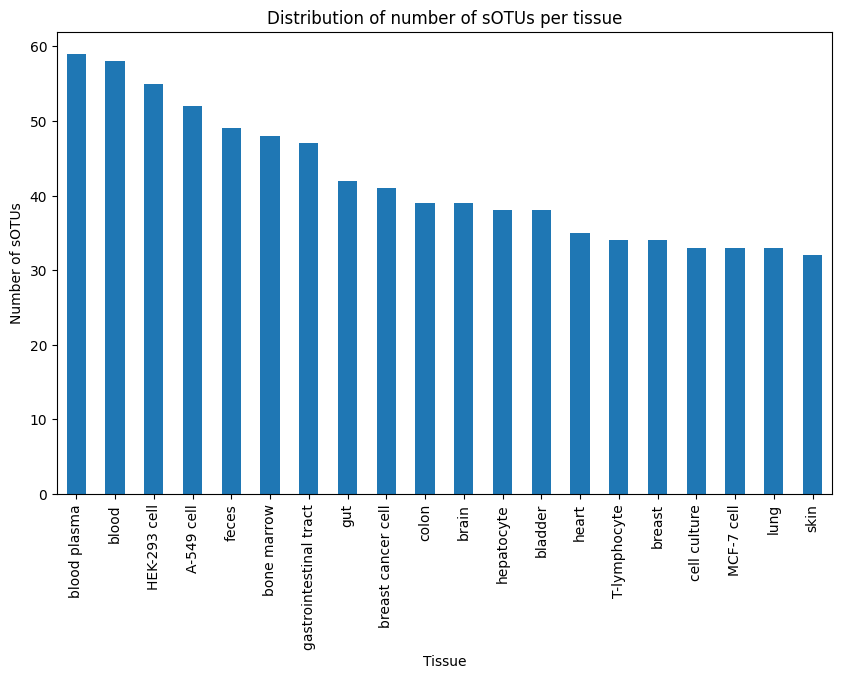

In [131]:
# Resample sOTU tissue dataset to have an equal number of sOTUs per tissue

resampled_sotu_tissues = get_resampled_tissues(sotu_tissues)
print(resampled_sotu_tissues.head())

plt.figure(figsize=(10, 6))
resampled_sotu_tissues['scientificName'].value_counts().head(20).plot(kind='bar')
plt.xlabel('Tissue')
plt.ylabel('Number of sOTUs')
plt.title('Distribution of number of sOTUs per tissue')
plt.show()


         nunique  count
sotu                   
u38270      1195   1195
u37806      1025   1025
u906064      856    856
u113835      853    853
u207044      831    831
u202260      768    768
u410517      740    740
u727093      707    707
u237705      691    691
u226460      672    672
         nunique  count
sotu                   
u38270       149   1195
u37806       120   1025
u906064       86    856
u113835       99    853
u207044      109    831
u202260       88    768
u410517       79    740
u727093       68    707
u237705       82    691
u226460       69    672
          nodeId  tissueNodeId        btoId scientificName  numRuns
sotu                                                               
u98342   7880565      11258228  BTO_0000782   T-lymphocyte     2919
u113835  7896759      11257920  BTO_0000089          blood     2802
u38270   7768298      11257920  BTO_0000089          blood     2430
u37806   7766115      11257920  BTO_0000089          blood     1805
u40014   7772052

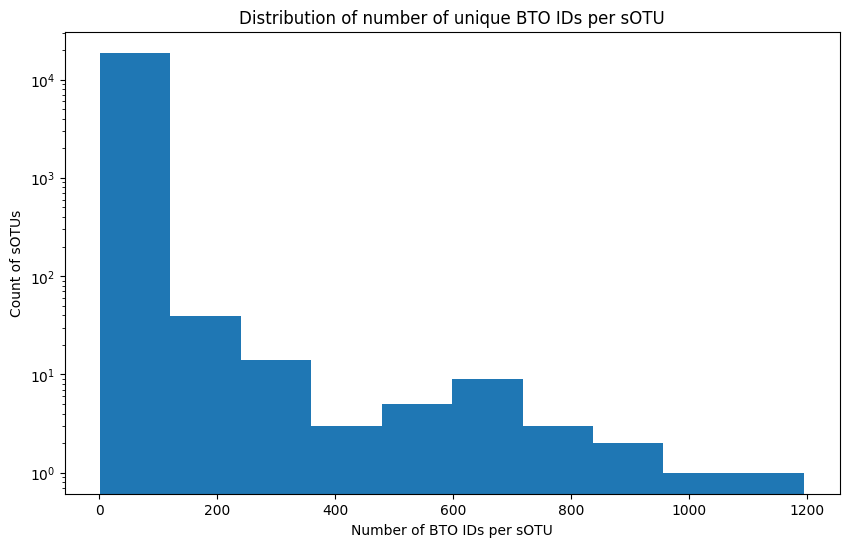

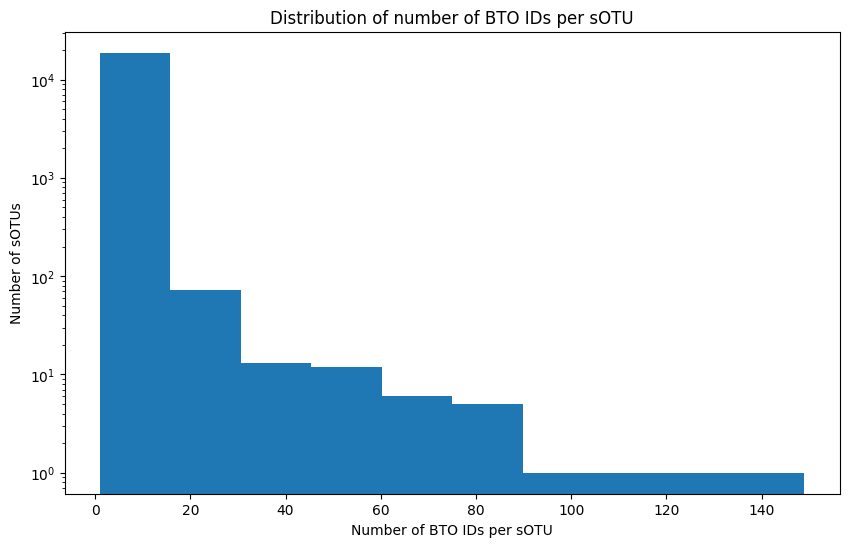

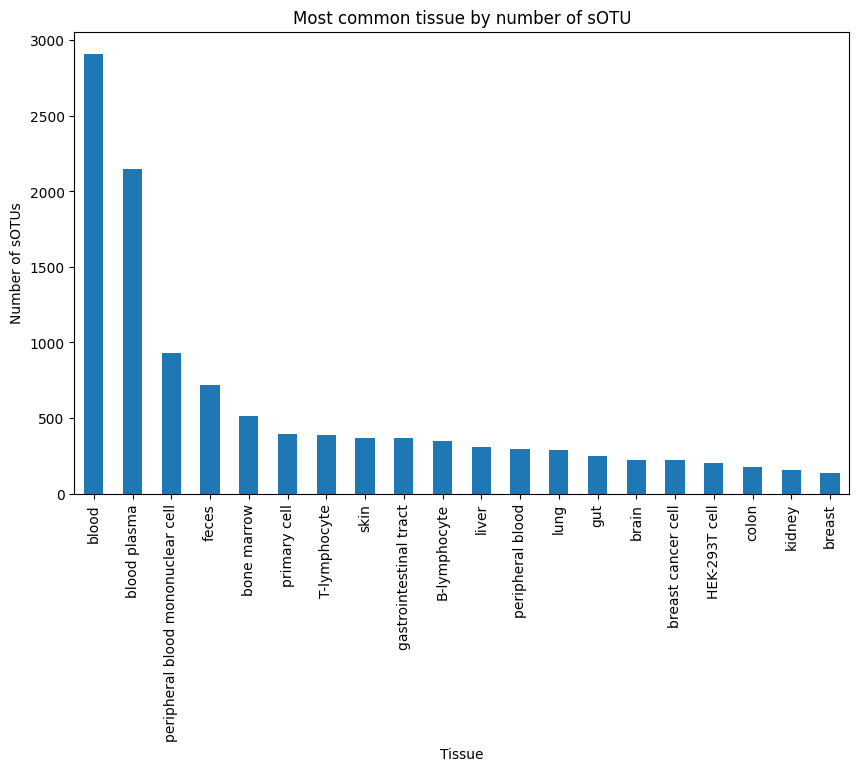

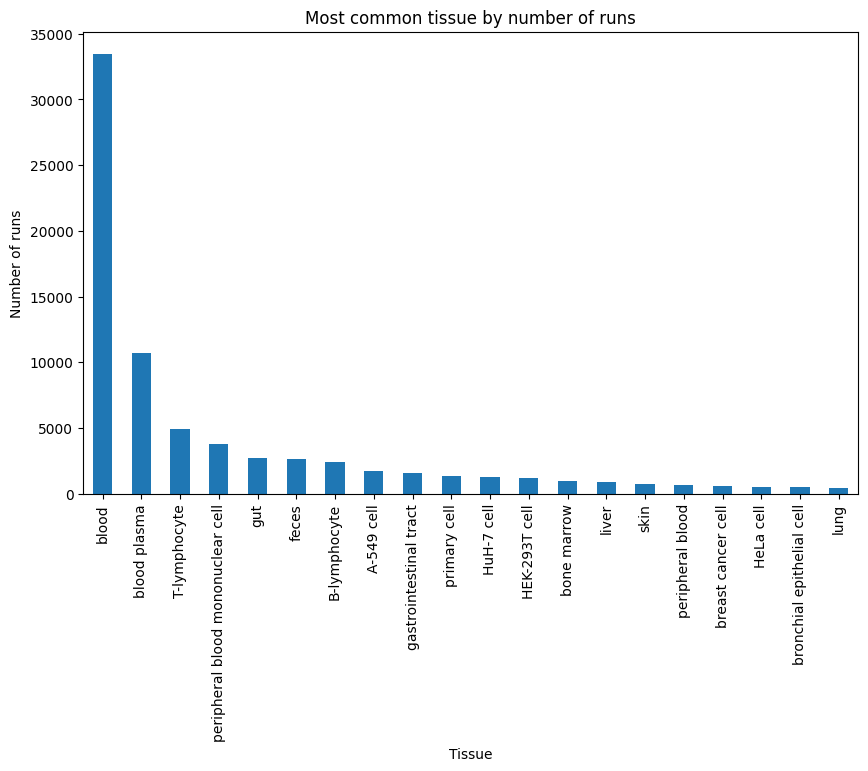

In [132]:
# get stats of btoId per sotu
btoId_stats = sotu_tissues.groupby('sotu')['btoId'].agg(['nunique', 'count'])
print(btoId_stats.sort_values('count', ascending=False).head(10))

# plot distribution of number of btoIds per sotu
plt.figure(figsize=(10, 6))
btoId_stats['nunique'].plot(kind='hist')
plt.xlabel('Number of BTO IDs per sOTU')
plt.ylabel('Count of sOTUs')
plt.title('Distribution of number of unique BTO IDs per sOTU')
plt.yscale('log')

# use numRuns as a proxy for the number of samples
run_stats = sotu_tissues.groupby('sotu')['numRuns'].agg(['nunique', 'count'])
print(run_stats.sort_values('count', ascending=False).head(10))


plt.figure(figsize=(10, 6))
run_stats['nunique'].plot(kind='hist')
plt.xlabel('Number of BTO IDs per sOTU')
plt.ylabel('Number of sOTUs')
plt.title('Distribution of number of BTO IDs per sOTU')
plt.yscale('log')


print(most_common_btoId.sort_values('numRuns', ascending=False).head(10))


# plot by number of sOTUs
plt.figure(figsize=(10, 6))
most_common_btoId['scientificName'].value_counts().head(20).plot(kind='bar')
plt.xlabel('Tissue')
plt.ylabel('Number of sOTUs')
plt.title('Most common tissue by number of sOTU')
plt.show()

# plot by number of runs
plt.figure(figsize=(10, 6))
most_common_btoId.groupby('scientificName')['numRuns'].sum().sort_values(ascending=False).head(20).plot(kind='bar')
plt.xlabel('Tissue')
plt.ylabel('Number of runs')
plt.title('Most common tissue by number of runs')
plt.show()



In [133]:
# v2: create projection using neo4j db properties + cypher queries

gds = get_gds_client()

def remove_all_sotu_seed_properties():
    query = '''
        MATCH (n:SOTU)
        REMOVE n.seedId, n.seedWeight
    '''
    return query_gds(query)

def set_sotu_seed_property(rows):
    query = '''
        UNWIND $rows as row
        MERGE (n:SOTU {sotu: row.sotu})
        SET n += {
            seedId: row.seedId,
            seedWeight: row.weight
        }
    '''
    return batch_insert_data(query, rows)

# nodes = pd.read_csv(f'{DATA_DIR}/sotu_tissue_nodes_seed.csv')]
nodes = most_common_btoId
nodes = add_node_weight_property(nodes)

if RESAMPLE_DATASET:
    nodes = nodes[
        nodes['nodeId'].isin(resampled_sotu_tissues['nodeId'])
    ]

np.random.seed(RANDOM_SEED)
mask = np.random.choice([0, 1], size=nodes.shape[0], p=[MASK_RATIO, 1 - MASK_RATIO])
nodes['seedId'] = np.where(mask == 0, None, nodes['seedId'])
nodes['weight'] = np.where(mask == 0, 0, nodes['weight'])
nodes['test'] = np.where(mask == 0, 1, 0)


nodes = dd.from_pandas(nodes, chunksize=10000)
# seed_nodes = resampled[['nodeId', 'avg_length', 'seedWeight']]
# resampled = resampled.to_dict(orient='records')
set_sotu_seed_property(nodes)

gds = get_gds_client()
undirected_relationship_types = ['SEQUENCE_ALIGNMENT']

if gds.graph.exists(SOTU_TISSUE_PROJECTION_NAME)['exists']:
    gds.graph.drop(gds.graph.get(SOTU_TISSUE_PROJECTION_NAME))

projection = gds.graph.project(
    graph_name=SOTU_TISSUE_PROJECTION_NAME,
    node_spec={
        'SOTU': {
            'properties': ['seedId', 'seedWeight'],
        }
    },
    relationship_spec={'SEQUENCE_ALIGNMENT': {'properties': ['percentIdentity'], 'orientation':'UNDIRECTED'}},
)

remove_all_sotu_seed_properties()

nodes = nodes.compute()

# Not used in projection, for plots
relationships = get_sotu_tissue_rels(sotu_tissues)
relationships = relationships[[
    'sourceNodeId',
    'targetNodeId',
    'relationshipType',
    'percentIdentity'
]]
relationships['relationshipType'] = 'SEQUENCE_ALIGNMENT'
relationships = relationships[
    relationships['sourceNodeId'].isin(nodes['nodeId']) &
    relationships['targetNodeId'].isin(nodes['nodeId'])
]
relationships['percentIdentity'] = relationships['percentIdentity'].round(2)

Processed 0 nodes
Processed 1000 nodes
Processed 2000 nodes
Processed 3000 nodes
Processed 4000 nodes
Processed 5000 nodes
Processed 6000 nodes
Processed 7000 nodes
Processed 8000 nodes
Processed 9000 nodes
Processed 10000 nodes
Processed 11000 nodes
Processed 12000 nodes
Processed 13000 nodes
Processed 14000 nodes
Processed 15000 nodes
Processed 16000 nodes
Processed 17000 nodes
Processed 18000 nodes


0.5022039377020276


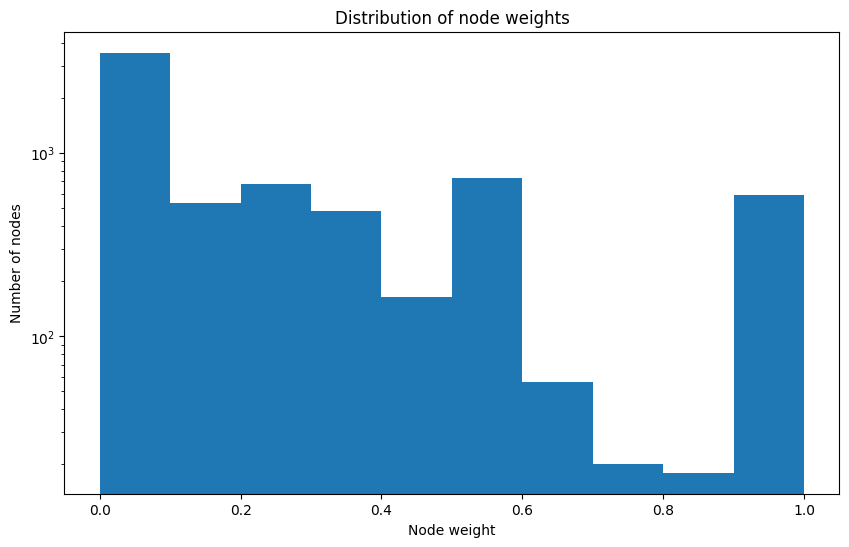

In [134]:
# get distribution of test nodes and node weights

test_nodes = nodes[nodes['test'] == 1]
test_nodes_percentage = test_nodes.shape[0] / nodes.shape[0]
print(test_nodes_percentage)

plt.figure(figsize=(10, 6))
nodes['weight'].plot(kind='hist')
plt.xlabel('Node weight')
plt.ylabel('Number of nodes')
plt.title('Distribution of node weights')
plt.yscale('log')
plt.show()

communityId
162        1362
236        1165
1587        663
1231        613
470         463
           ... 
8271258       1
8271256       1
8271251       1
8271250       1
8271271       1
Length: 476209, dtype: int64


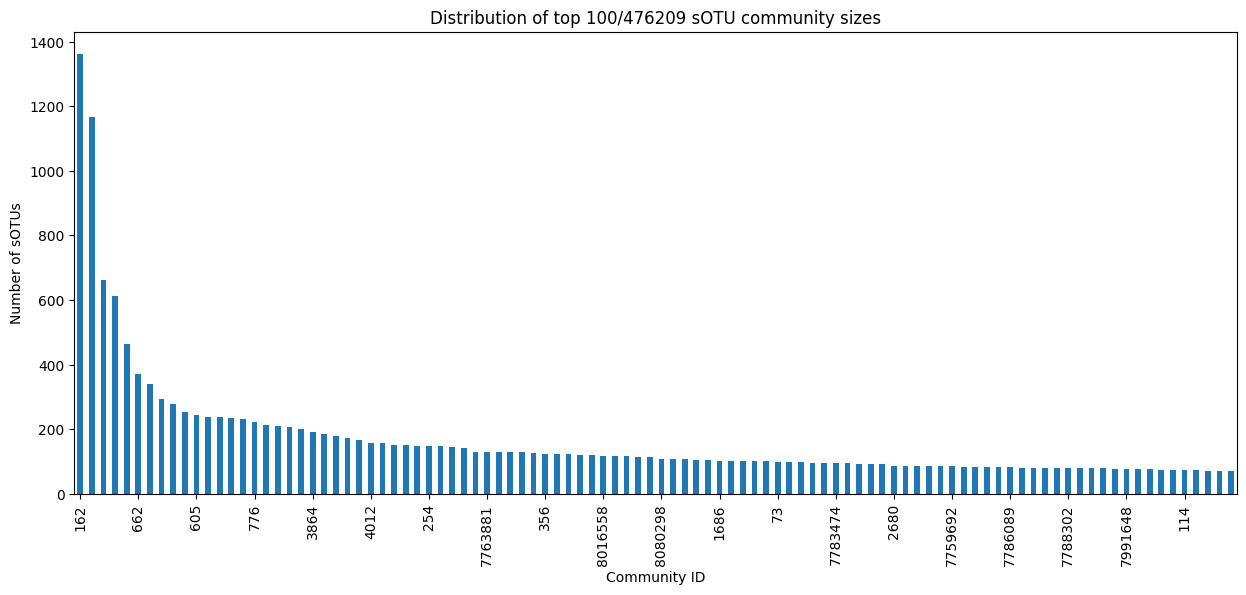

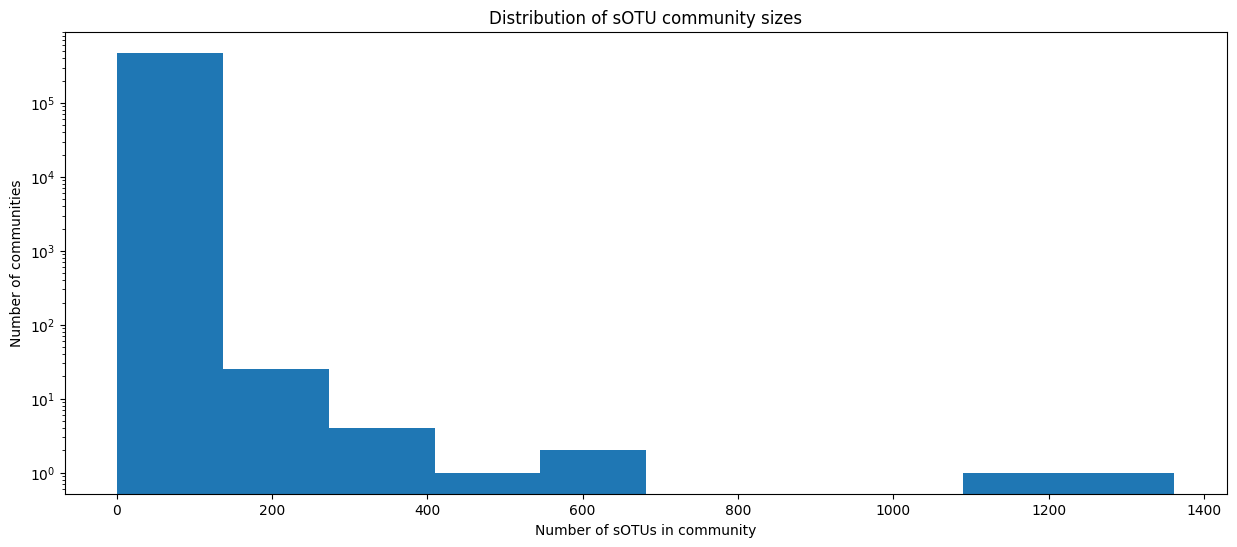

In [135]:
# LPA / community detection
projection = gds.graph.get(SOTU_TISSUE_PROJECTION_NAME)
communities = get_lpa_communities(projection, node_weight_property='seedWeight', seed_property='seedId')
# communities = get_leiden_communities(projection, seed_property='seedId')
# communities = get_louvain_communities(projection, seed_property='seedId')
# communities = get_wcc_communities(projection, seed_property='seedId')
if 'componentId' in communities.columns:
    communities['communityId'] = communities['componentId']
plot_communities(communities)
plot_communities_histogram(communities)

In [136]:
# Evaluate the quality of the communities
community_stats, correct_sotus, incorrect_sotus = get_community_stats(communities, sotu_to_tissues, sotu_to_node_id, nodes)

Processing community 0...
Processing community 1000...
Processing community 2000...
Processing community 3000...
Processing community 4000...
Processing community 5000...
Processing community 6000...
Processing community 7000...
Processing community 8000...
Processing community 9000...
Processing community 10000...
Processing community 11000...
Processing community 12000...
Processing community 13000...
Processing community 14000...
Processing community 15000...
Processing community 16000...
Processing community 17000...
Processing community 18000...
Processing community 19000...
Processing community 20000...
Processing community 21000...
Processing community 22000...
Processing community 23000...
Processing community 24000...
Processing community 25000...
Processing community 26000...
Processing community 27000...
Processing community 28000...
Processing community 29000...
Processing community 30000...
Processing community 31000...
Processing community 32000...
Processing community 33

In [137]:
correct = sum([stats['correct'] for stats in community_stats.values()])
incorrect = sum([stats['incorrect'] for stats in community_stats.values()])

print(correct)
print(incorrect)
print(correct / (correct + incorrect))

969
794
0.5496313102665911


## Projection: sOTU-Tissue nodes

In [55]:
# v2: create projection using tmp neo4j db edges and nodes

SOTU_TISSUE_PROJECTION_NAME = 'SOTU-tissue-dataset'

gds = get_gds_client()
if gds.graph.exists(SOTU_TISSUE_PROJECTION_NAME)['exists']:
    gds.graph.drop(gds.graph.get(SOTU_TISSUE_PROJECTION_NAME))


def add_sotu_tissue_relationships(rows):
    query = '''
        UNWIND $rows as row
        MATCH (n:SOTU {sotu: row.sotu}), (m:Tissue {btoId: row.btoId})
        MERGE (n)-[r:HAS_TISSUE]->(m)
        SET r.percentIdentity = row.percentIdentity
    '''
    return batch_insert_data(query, rows)

def remove_all_sotu_tissue_relationships():
    query = '''
        MATCH (n:SOTU)-[r:HAS_TISSUE]->(m:Tissue)
        DELETE r
    '''
    return query_gds(query)


def add_sotu_host_relationships(rows):
    query = '''
        UNWIND $rows as row
        MATCH (n:SOTU {sotu: row.sotu}), (m:Taxon {taxId: row.taxId})
        MERGE (n)-[r:HAS_HOST]->(m)
        SET r.percentIdentity = row.percentIdentity
    '''
    return batch_insert_data(query, rows)


def remove_all_sotu_host_relationships():
    query = '''
        MATCH (n:SOTU)-[r:HAS_HOST]->(m:Taxon)
        DELETE r
    '''
    return query_gds(query)

query = '''
    MATCH (source)
    WHERE source:SOTU or source:Tissue
    OPTIONAL MATCH (source)-[r:SEQUENCE_ALIGNMENT|HAS_TISSUE]->(target)
    WHERE target:SOTU or target:Tissue
    WITH gds.graph.project(
        'SOTU-tissue-dataset',
        source,
        target,
        {
            relationshipProperties: r { percentIdentity: coalesce(r.percentIdentity, 0.5) }
        },
        {
            undirectedRelationshipTypes: ['*']
        }
    ) as g
    RETURN g
'''

remove_all_sotu_tissue_relationships()
remove_all_sotu_host_relationships()

if USE_HUMAN_TISSUE_ONLY:
    nodes = get_human_tissues()
    nodes['percentIdentity'] = nodes.groupby('sotu')['numRuns'].transform(lambda x: x / x.sum())

    ## only use most common tissues
    # nodes = most_common_btoId
    # nodes = add_node_weight_property(nodes)
else:
    nodes = get_sotu_nodes_with_tissue()

if RESAMPLE_DATASET:
    resampled_nodes = get_resampled_tissues(nodes)
    nodes = nodes[
        nodes['nodeId'].isin(resampled_nodes['nodeId'])
    ]

if USE_HOST_RELS:
    # host_rels = get_sotu_has_host_metadata_edges()
    host_rels = get_sotu_has_host_stat_edges()
    host_rels = host_rels.rename(columns={
        'sourceAppId': 'sotu',
        'targetAppId': 'taxId',
        'avgPercentIdentityStatKmers': 'percentIdentity'
    })
    host_rels_dd = dd.from_pandas(host_rels, chunksize=10000)
    add_sotu_host_relationships(host_rels_dd)

np.random.seed(RANDOM_SEED)

## mask by sotus
distinct_sotus = nodes['sotu'].unique()
mask = np.random.choice([0, 1], size=len(distinct_sotus), p=[MASK_RATIO, 1 - MASK_RATIO])
mask_df = pd.DataFrame({
    'sotu': distinct_sotus,
    'test': mask,
})
nodes = nodes.merge(mask_df, on='sotu', how='left')

## mask by tissue associations
# mask = np.random.choice([0, 1], size=nodes.shape[0], p=[MASK_RATIO, 1 - MASK_RATIO])
# nodes['test'] = np.where(mask == 0, 1, 0)

masked_nodes = nodes[nodes['test'] == 1]
sotu_tissues_dd = dd.from_pandas(masked_nodes, chunksize=10000)

add_sotu_tissue_relationships(sotu_tissues_dd)

projection = query_gds(query)
remove_all_sotu_tissue_relationships()
remove_all_sotu_host_relationships()

""


519745
369069
communityId
43339     15084
15038      8472
2100       7293
60811      5345
45768      5223
          ...  
271474        1
271473        1
271472        1
271471        1
271483        1
Length: 369069, dtype: int64


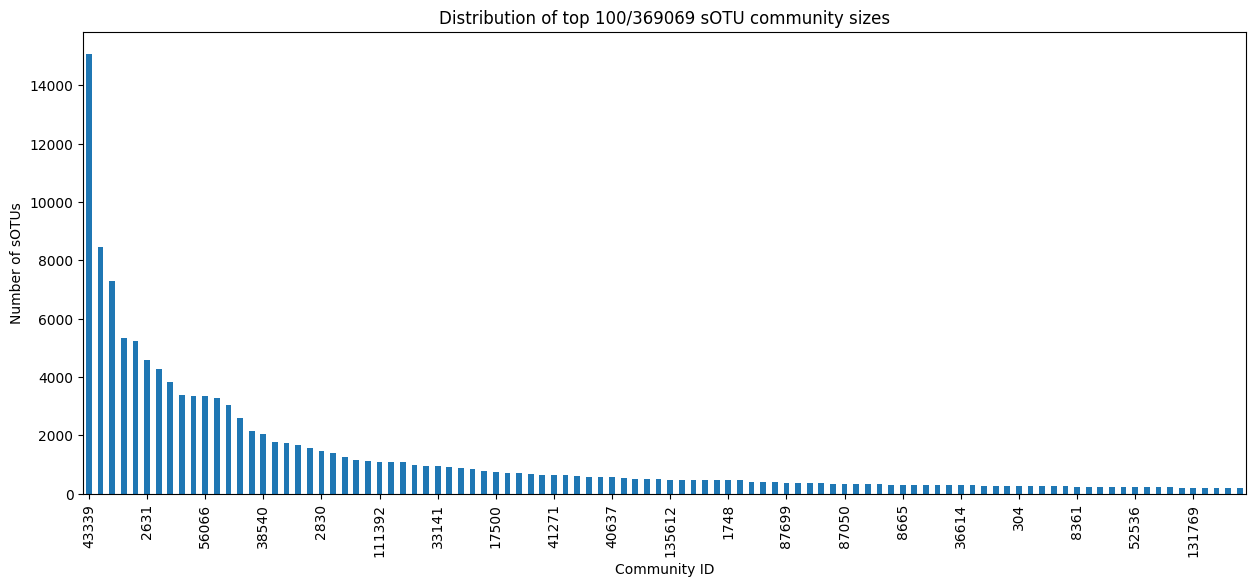

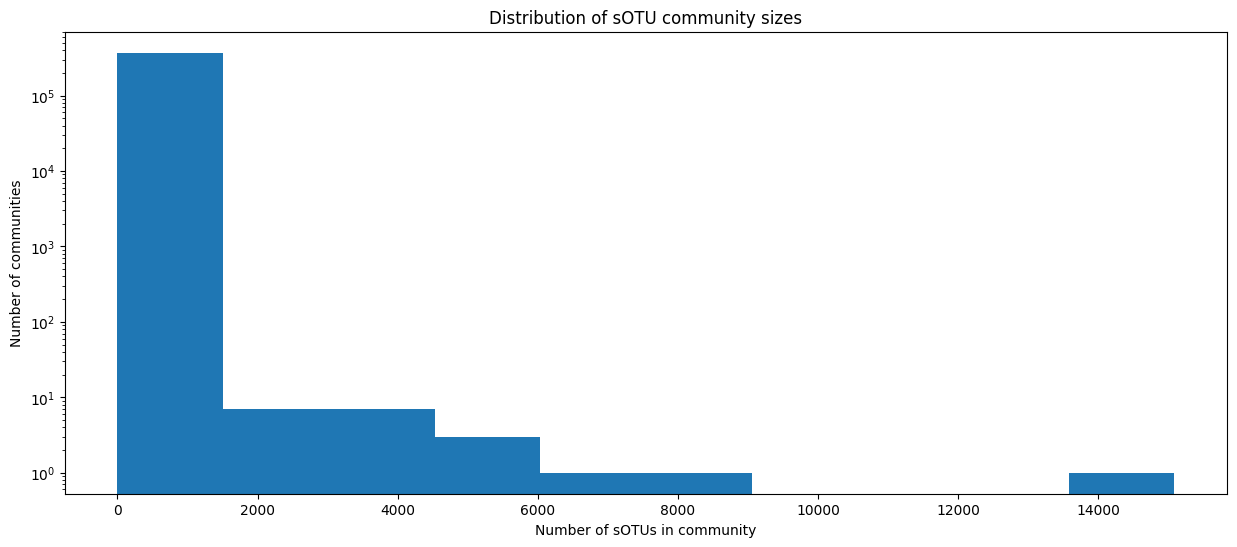

In [56]:
# LPA / community detection
projection = gds.graph.get(SOTU_TISSUE_PROJECTION_NAME)
# communities = get_lpa_communities(projection, node_weight_property=None, seed_property='seedId', edge_weight_property='weight')
# communities = get_lpa_communities(projection, node_weight_property=None, seed_property=None, edge_weight_property='percentIdentity')
communities = get_leiden_communities(projection, edge_weight_property='percentIdentity')
# communities = get_louvain_communities(projection, seed_property='seedId')
# communities = get_wcc_communities(projection, seed_property='seedId')
if 'componentId' in communities.columns:
    communities['communityId'] = communities['componentId']

print(communities.shape[0])
print(communities['communityId'].nunique())
plot_communities(communities)
plot_communities_histogram(communities)

In [57]:
print(nodes['test'].value_counts())

1    52388
0    51887
Name: test, dtype: int64


In [58]:
# sotu_to_tissues = sotu_tissues.groupby('sotu')['btoId'].apply(set).to_dict()
community_stats, correct_sotus, incorrect_sotus = get_community_stats(communities, sotu_to_tissues, sotu_to_node_id, nodes)

Processing community 0...
Processing community 1000...
Processing community 2000...
Processing community 3000...
Processing community 4000...
Processing community 5000...
Processing community 6000...
Processing community 7000...
Processing community 8000...
Processing community 9000...
Processing community 10000...
Processing community 11000...
Processing community 12000...
Processing community 13000...
Processing community 14000...
Processing community 15000...
Processing community 16000...
Processing community 17000...
Processing community 18000...
Processing community 19000...
Processing community 20000...
Processing community 21000...
Processing community 22000...
Processing community 23000...
Processing community 24000...
Processing community 25000...
Processing community 26000...
Processing community 27000...
Processing community 28000...
Processing community 29000...
Processing community 30000...
Processing community 31000...
Processing community 32000...
Processing community 33

In [59]:
correct = sum([stats['correct'] for stats in community_stats.values()])
incorrect = sum([stats['incorrect'] for stats in community_stats.values()])

print(correct)
print(incorrect)
print(correct / (correct + incorrect))
print(len(correct_sotus) / (len(correct_sotus) + len(incorrect_sotus)))

44819
7569
0.8555203481713369
0.8555203481713369


## Eval/plots

In [144]:
# plot distribution of percentIdentity in common communities
community_to_tissue_map = get_tissue_to_community_id()
bto_id_to_scientific_name = sotu_tissues.set_index('btoId')['scientificName'].to_dict()

def plot_community_percent_identity_distribution(communities, relationships):
    community_sizes = communities.groupby('communityId').size()
    community_sizes = pd.Series(community_sizes)
    community_sizes = community_sizes.sort_values(ascending=False)
    top_communities = community_sizes.head(10).index
    for community_id in top_communities:
        community = communities[communities['communityId'] == community_id]
        community_relationships = relationships[
            relationships['sourceNodeId'].isin(community['nodeId']) &
            relationships['targetNodeId'].isin(community['nodeId'])
        ]
        plt.figure(figsize=(10, 6))
        community_relationships['percentIdentity'].plot(kind='hist')
        plt.xlabel('Percent Identity')
        plt.ylabel('Number of relationships')
        plt.title(f'Distribution of percent identity in community {community_id}')
        plt.show()
        
plot_community_percent_identity_distribution(communities, relationships)

KeyError: 'btoId'

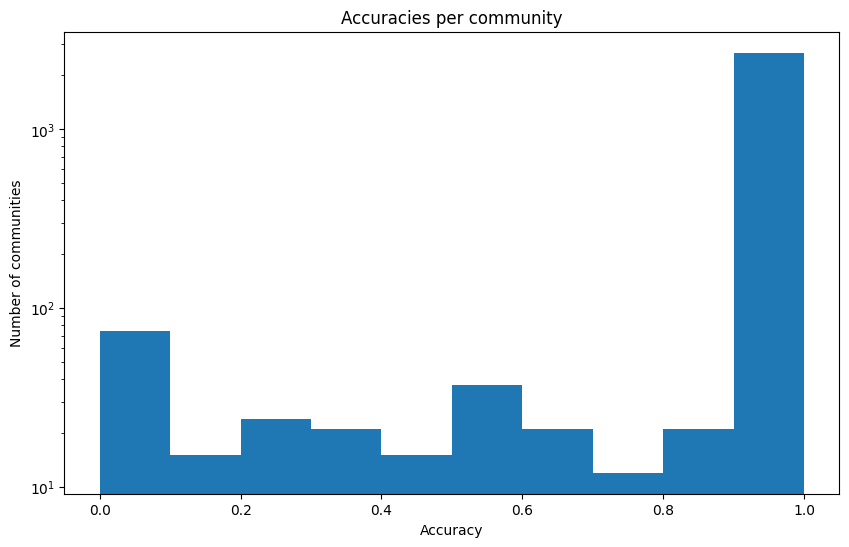

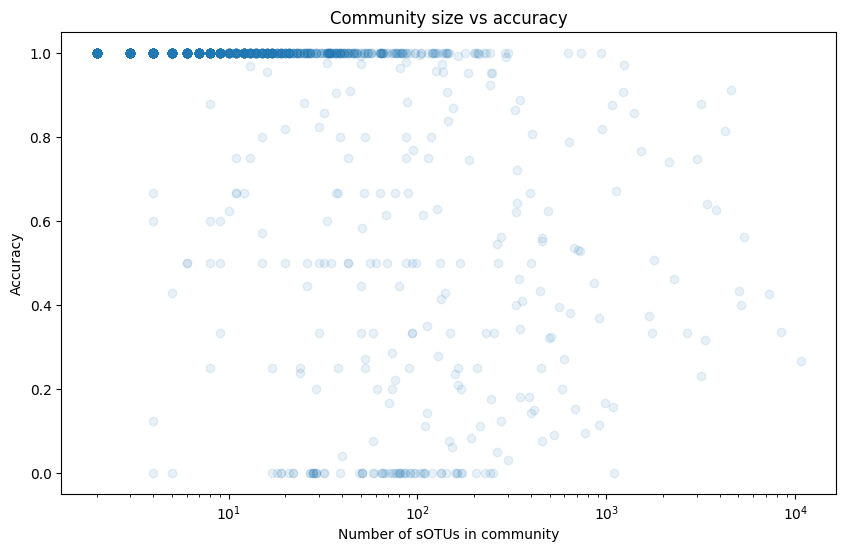

In [92]:
# plot community size vs accuracy

community_accuracies = pd.Series([stats['accuracy'] for stats in community_stats.values()])
plt.figure(figsize=(10, 6))
plot_data = community_accuracies.T
plot_data.plot(kind='hist')
# community_accuracies.plot(kind='hist')
plt.xlabel('Accuracy')
plt.ylabel('Number of communities')
plt.title('Accuracies per community')
plt.yscale('log')
plt.show()


plot_data = pd.DataFrame(community_stats).T
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['total_sotus'], plot_data['accuracy'], alpha=0.1)

plt.xlabel('Number of sOTUs in community')
plt.ylabel('Accuracy')
plt.title('Community size vs accuracy')
plt.xscale('log')
plt.show()

25861
8316
0.7566784679755391


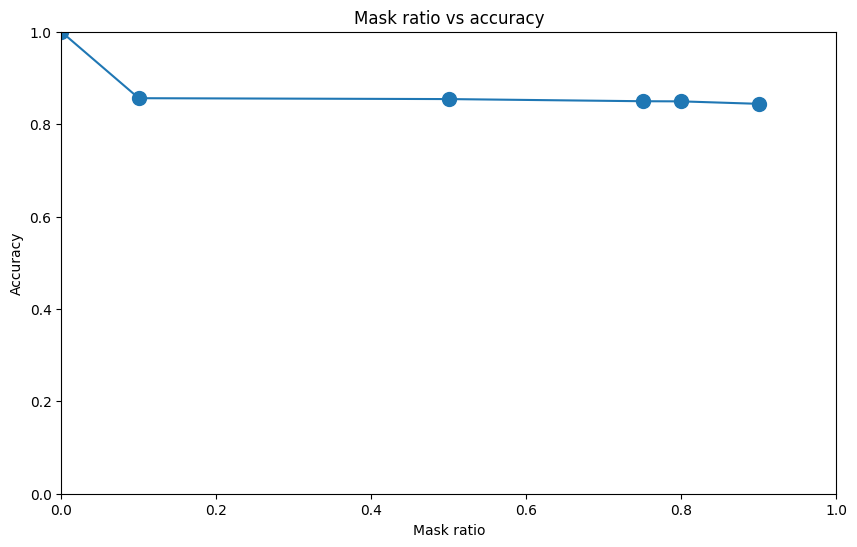

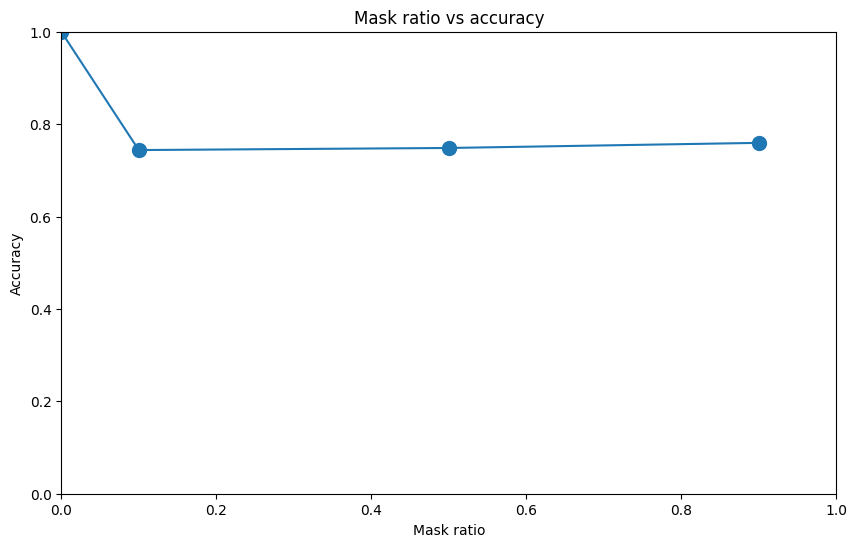

In [87]:
correct = sum([stats['correct'] for stats in community_stats.values()])
incorrect = sum([stats['incorrect'] for stats in community_stats.values()])

print(correct)
print(incorrect)
print(correct / (correct + incorrect))

# original data
mask_ratio_to_accuracy = {
    0.0: 1,
    0.1: 0.8561162197666332,
    0.5: 0.8542060289395318,
    0.75: 0.8495564687250934,
    0.8: 0.8492601367096474,
    0.9: 0.8438897730850683,
    # 1: 0.8607651452797664,
}

# resampled data
mask_ratio_to_accuracy_resampled = {
    0.0: 1,
    0.1: 0.7438638759223009,
    0.5: 0.7483669922694313,
    0.9: 0.7594402340114347,
}

# human data
mask_ratio_to_accuracy_human_leiden = {
    0.0: 1,
    0.1: 0.7438638759223009,
    0.5: 0.7483669922694313,
    0.9: 0.7594402340114347,
}

# plot mask ratio vs accuracy as line plot
def plot_mask_ratio_vs_accuracy(mask_ratio_to_accuracy):
    mask_ratio_to_accuracy = pd.Series(mask_ratio_to_accuracy)
    plt.figure(figsize=(10, 6))
    mask_ratio_to_accuracy.plot()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xlabel('Mask ratio')
    plt.ylabel('Accuracy')
    plt.title('Mask ratio vs accuracy')
    plt.scatter(mask_ratio_to_accuracy.index, mask_ratio_to_accuracy.values, s=100)
    plt.show()

plot_mask_ratio_vs_accuracy(mask_ratio_to_accuracy)
plot_mask_ratio_vs_accuracy(mask_ratio_to_accuracy_resampled)


In [118]:
# plot most common bto ids in correct sotus
print(len(correct_sotus))
correct_counter = Counter()

for sotu in correct_sotus:
    node_id = sotu_to_node_id[sotu_to_node_id['sotu'] == sotu]['nodeId'].values[0]
    community_id = communities[communities['nodeId'] == node_id]['communityId'].values[0]
    most_common_tissue = community_stats[community_id]['most_common_tissue']
    # get scientific name of tissue
    name = bto_to_name[most_common_tissue]
    correct_counter[name] += 1

plt.figure(figsize=(10, 6))
plot_data = pd.Series(correct_counter)
plot_data = plot_data.sort_values(ascending=False)
plot_data = plot_data.head(20)
print(plot_data)
plot_data.plot(kind='bar')
plt.xlabel('Tissue')
plt.ylabel('Number of sOTUs')
plt.title('Most common tissue in correctly predicted sOTUs')
plt.yscale('log')
plt.show()

5208


KeyboardInterrupt: 

4087
blood                                1814
blood plasma                          914
peripheral blood mononuclear cell     183
feces                                 113
lung                                  110
T-lymphocyte                           79
brain                                  73
breast                                 62
gastrointestinal tract                 60
primary cell                           55
B-lymphocyte                           42
peripheral blood                       36
HEK-293T cell                          36
breast cancer cell                     34
kidney                                 28
colorectal cancer cell                 27
bone marrow                            26
HL-60 cell                             24
HCT-116 cell                           22
liver                                  20
dtype: int64


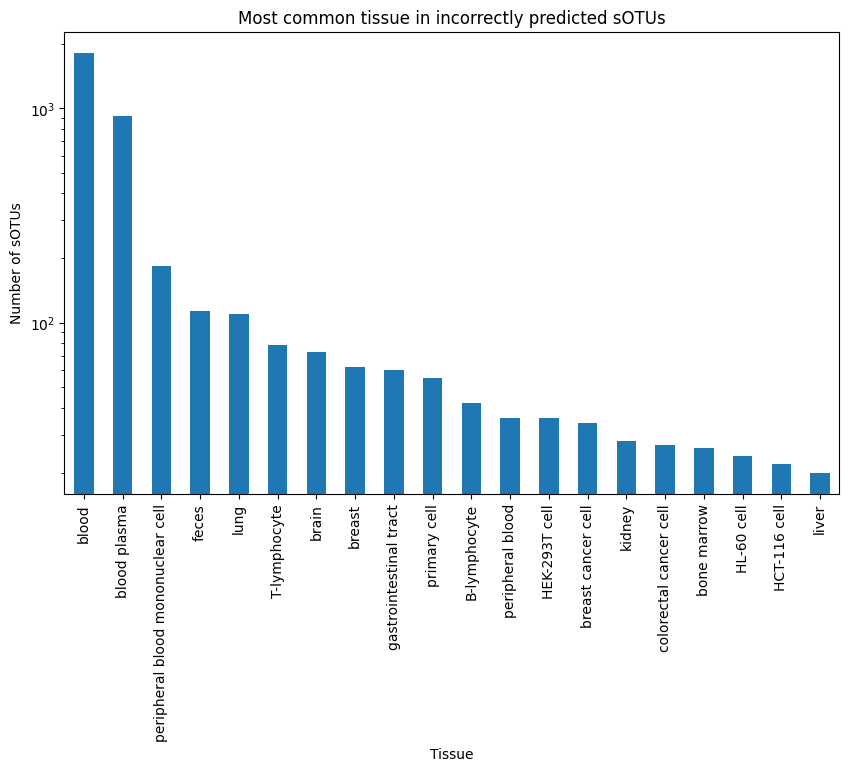

In [46]:
# plot most common bto ids in incorrect sotus
print(len(incorrect_sotus))
incorrect_counter = Counter()
bto_to_name = sotu_tissues.set_index('btoId')['scientificName'].to_dict()
for sotu in incorrect_sotus:
    # node_id = sotu_to_node_id[sotu_to_node_id['sotu'] == sotu]['nodeId'].values[0]
    node_id = sotu_to_node_id[sotu_to_node_id['sotu'] == sotu].index[0]
    community_id = communities[communities['nodeId'] == node_id]['communityId'].values[0]
    most_common_tissue = community_stats[community_id]['most_common_tissue']
    name = bto_to_name[most_common_tissue]
    incorrect_counter[name] += 1

plt.figure(figsize=(10, 6))
plot_data = pd.Series(incorrect_counter)
plot_data = plot_data.sort_values(ascending=False)
plot_data = plot_data.head(20)
print(plot_data)
plot_data.plot(kind='bar')
plt.xlabel('Tissue')
plt.ylabel('Number of sOTUs')
plt.title('Most common tissue in incorrectly predicted sOTUs')
# logscale
plt.yscale('log')
plt.show()


blood plasma
BTO_0000131


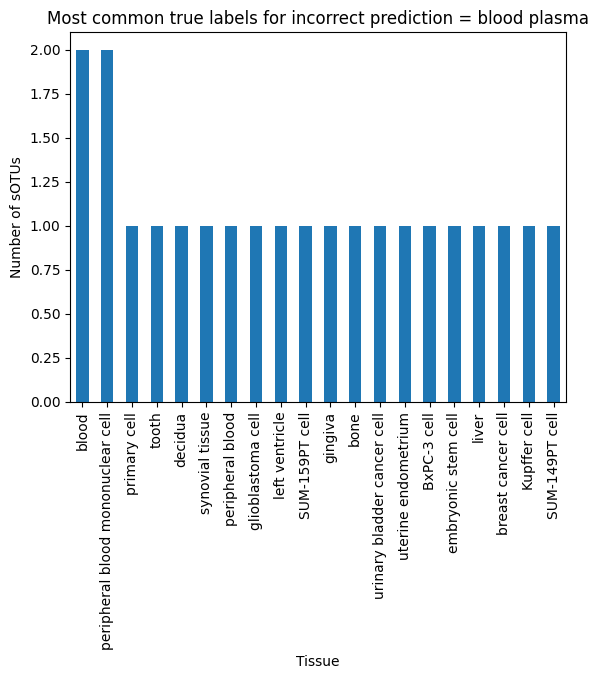

blood
BTO_0000089


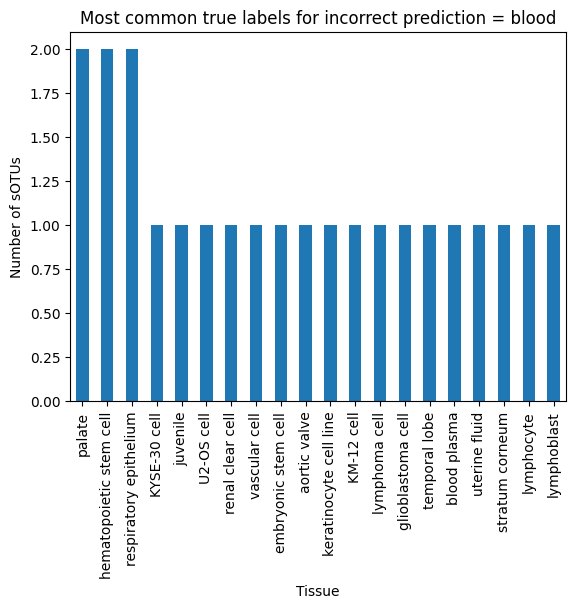

peripheral blood mononuclear cell
BTO_0001025


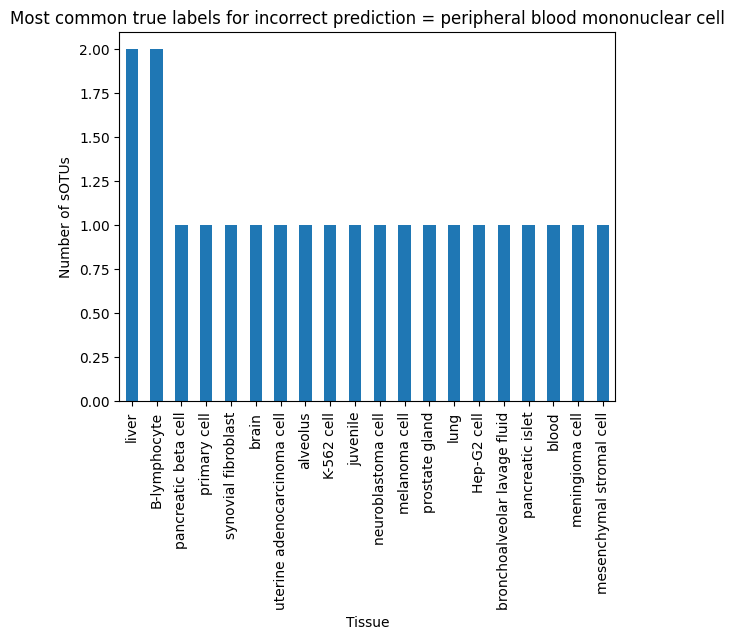

primary cell
BTO_0001413


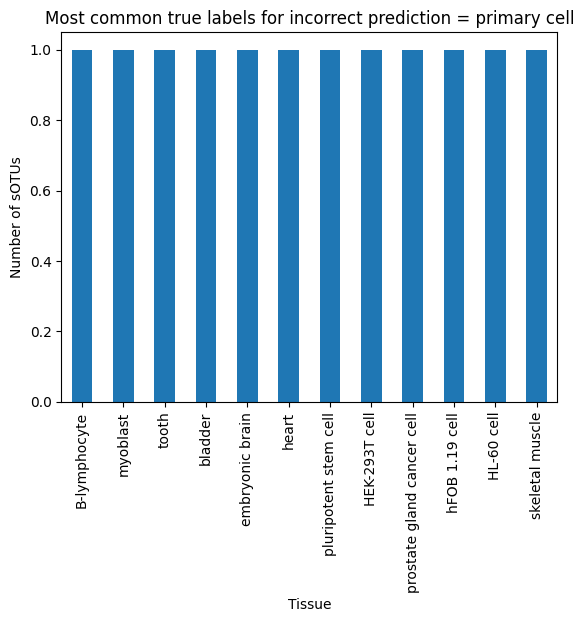

feces
BTO_0000440


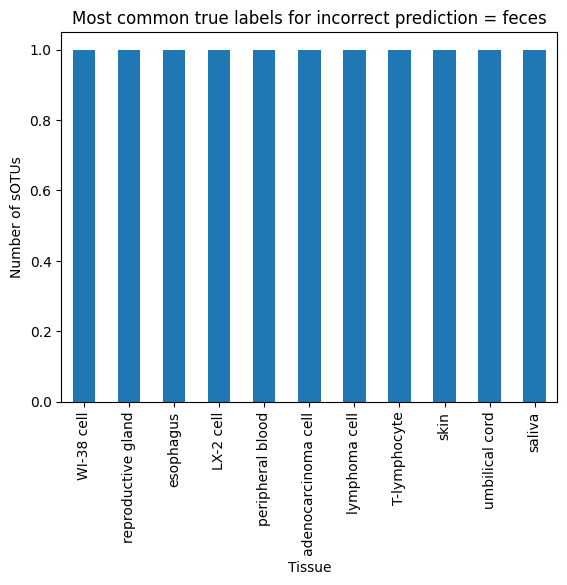

skin
BTO_0001253


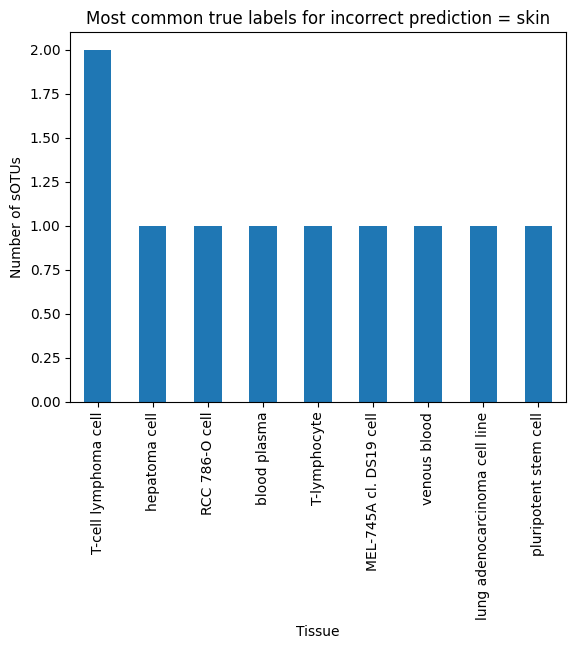

liver
BTO_0000759


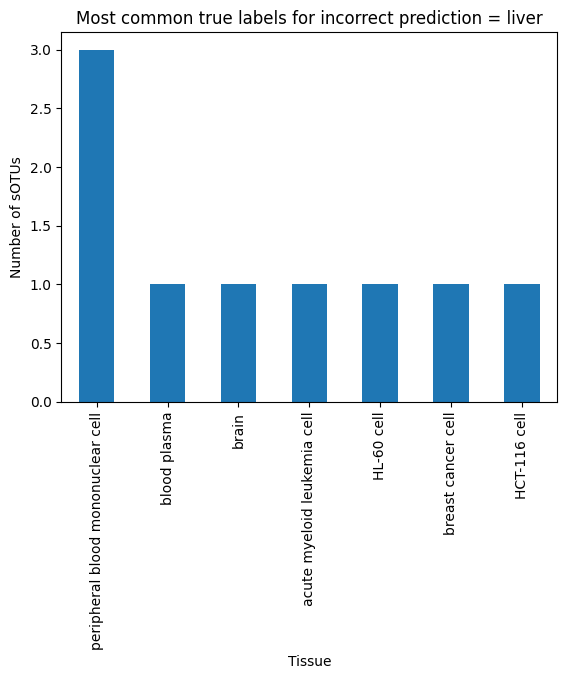

B-lymphocyte
BTO_0000776


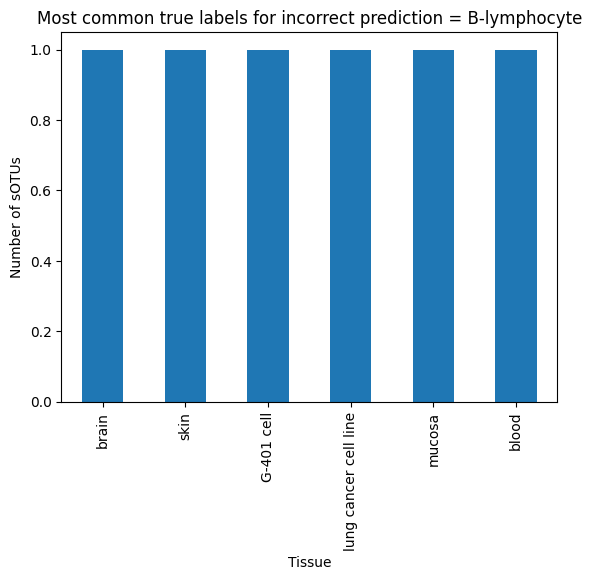

NOMO-1 cell
BTO_0005916


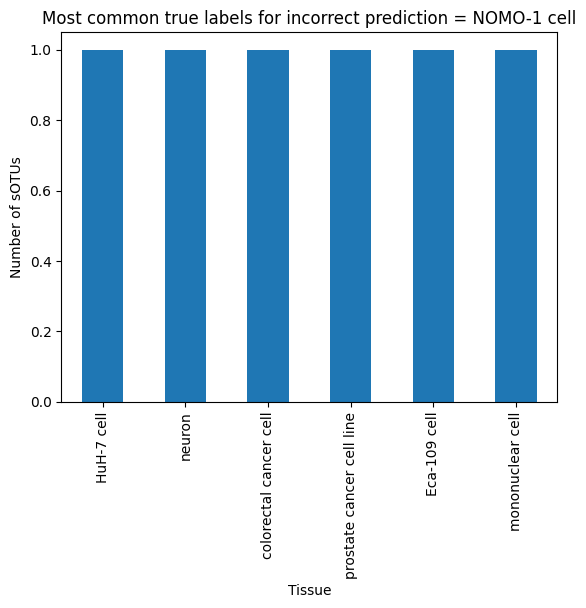

lung
BTO_0000763


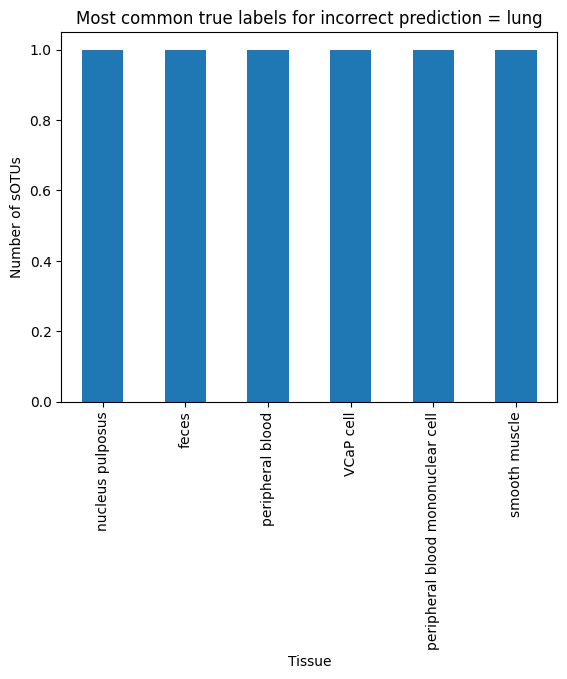

In [33]:
# for top incorrect tissue, plot the "true" most_common_btoId 

incorrect_debug_rows = []
for sotu in incorrect_sotus:
    node_id = sotu_to_node_id[sotu_to_node_id['sotu'] == sotu]['nodeId'].values[0]
    community_id = communities[communities['nodeId'] == node_id]['communityId'].values[0]
    predicted = community_stats[community_id]['most_common_tissue']
    actual = most_common_btoId.loc[sotu]['btoId']
    # actual = most_common_btoId[most_common_btoId['sotu'] == sotu]['btoId'].values[0]
    incorrect_debug_rows.append({
        'sotu': sotu,
        'predicted': predicted,
        'actual': actual,
    })
incorrect_debug_rows = pd.DataFrame(incorrect_debug_rows)


top_3_incorrect_preds = plot_data.nlargest(10)

for top_incorrect_tissue in top_3_incorrect_preds.index:
    print(top_incorrect_tissue)
    predicted_bto_id = sotu_tissues[sotu_tissues['scientificName'] == top_incorrect_tissue]['btoId'].values[0]
    print(predicted_bto_id)
    actual_values = incorrect_debug_rows[incorrect_debug_rows['predicted'] == predicted_bto_id]['actual'].value_counts()
    actual_values = actual_values.sort_values(ascending=False)
    actual_values = actual_values.head(20)
    actual_values = actual_values.rename(bto_to_name)
    actual_values.plot(kind='bar')
    plt.xlabel('Tissue')
    plt.ylabel('Number of sOTUs')
    plt.title(f'Most common true labels for incorrect prediction = {top_incorrect_tissue}')
    # plt.yscale('log')
    plt.show()


In [47]:
# plot avg percent identity in communities vs accuracy 

def get_community_avg_percent_identity(communities, relationships):
    community_ids = communities['communityId'].unique()
    community_avg_percent_identity = {}
    for community_id in community_ids:
        community_rows = communities[communities['communityId'] == community_id]
        community_relationships = relationships[
            relationships['sourceNodeId'].isin(community_rows['nodeId']) &
            relationships['targetNodeId'].isin(community_rows['nodeId'])
        ]
        avg_percent_identity = community_relationships['percentIdentity'].mean()
        community_avg_percent_identity[community_id] = avg_percent_identity
    return community_avg_percent_identity

community_avg_percent_identity = get_community_avg_percent_identity(communities, relationships)

plot_data = pd.DataFrame(community_stats).T
plot_data['avg_percent_identity'] = pd.Series(community_avg_percent_identity)
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['avg_percent_identity'], plot_data['accuracy'], alpha=0.1)
plt.xlabel('Average percent identity')
plt.ylabel('Accuracy')
plt.title('Average percent identity vs accuracy')
plt.show()

# plot avg percent identity in communities vs community size
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['avg_percent_identity'], plot_data['total_sotus'], alpha=0.1)
plt.xlabel('Average percent identity')
plt.ylabel('Community size')
plt.title('Average percent identity vs community size')
plt.show()


NameError: name 'relationships' is not defined

<Figure size 1500x1500 with 0 Axes>

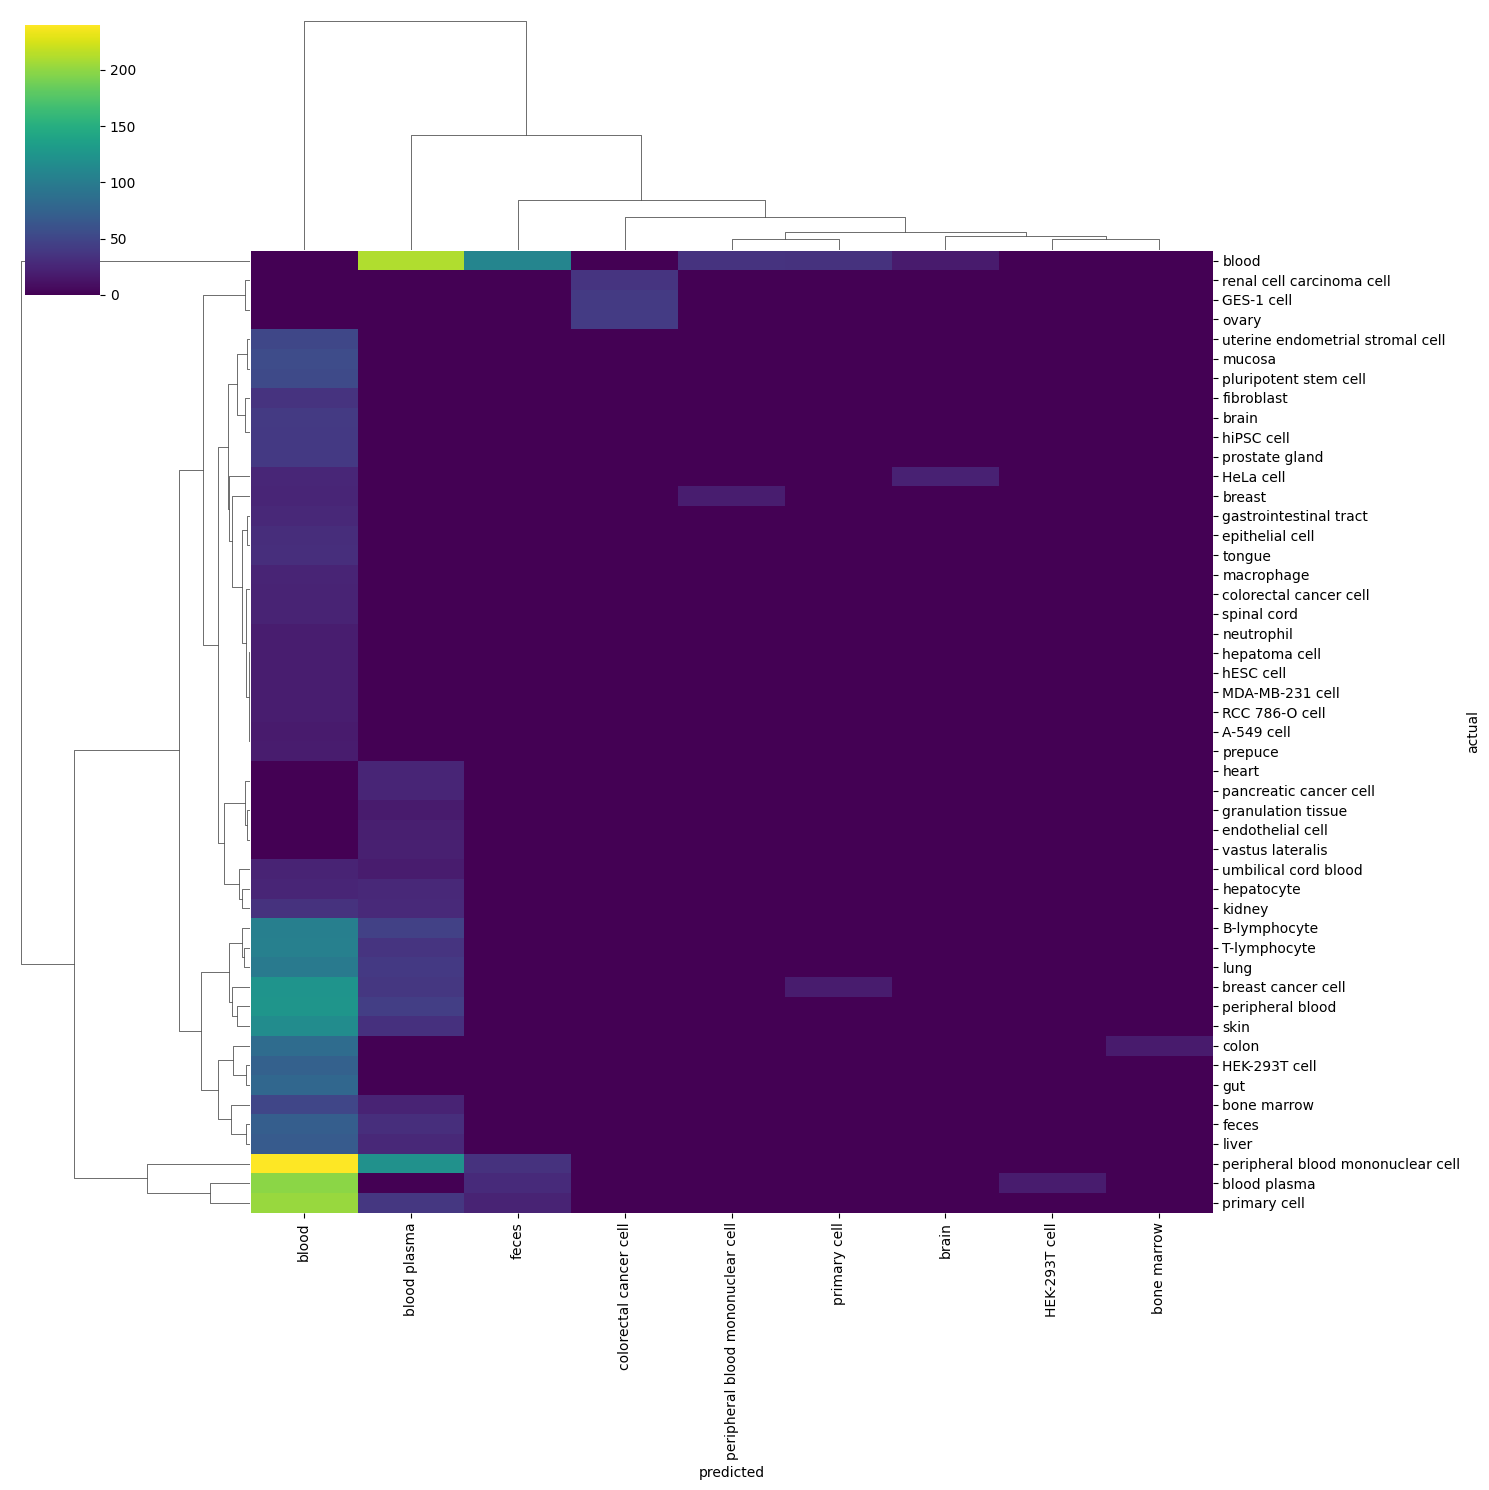

In [61]:
# plot heatmap of incorrect predictions

heatmap_rows = []

for sotu in incorrect_sotus:
    node_id = sotu_to_node_id[sotu_to_node_id['sotu'] == sotu].index[0]
    predicted_community_id = communities[communities['nodeId'] == node_id]['communityId'].values[0]
    predicted = community_stats[predicted_community_id]['most_common_tissue']
    predicted = bto_to_name[predicted]
    actual = most_common_btoId.loc[sotu]['btoId']
    actual_tissue_id = tissue_to_node_id[tissue_to_node_id['btoId'] == actual]['nodeId'].values[0]
    actual_community_id = communities[communities['nodeId'] == actual_tissue_id]['communityId'].values[0]
    actual = bto_to_name[actual]
    heatmap_rows.append({
        'sotu': sotu,
        # 'predicted': f'{predicted} ({predicted_community_id})',
        # 'actual': f'{actual} ({actual_community_id})',
        'predicted': predicted,
        'actual': actual,
    })

incorrect_debug_rows = pd.DataFrame(heatmap_rows)
# plot top 10 incorrect predictions
incorrect_debug_rows = incorrect_debug_rows[incorrect_debug_rows['actual'] != incorrect_debug_rows['predicted']]
incorrect_debug_rows = incorrect_debug_rows.groupby(['actual', 'predicted']).size().nlargest(75).unstack()

# incorrect_debug_rows = incorrect_debug_rows.groupby(['actual', 'predicted']).size().unstack()
# incorrect_debug_rows = incorrect_debug_rows.unstack()
incorrect_debug_rows = incorrect_debug_rows.fillna(0)
plt.figure(figsize=(15, 15))

# sns.heatmap(incorrect_debug_rows, cmap='viridis')
sns.clustermap(incorrect_debug_rows, cmap='viridis',  figsize=(15, 15)) # cbar=False, row_cluster=False, col_cluster=False
plt.show()


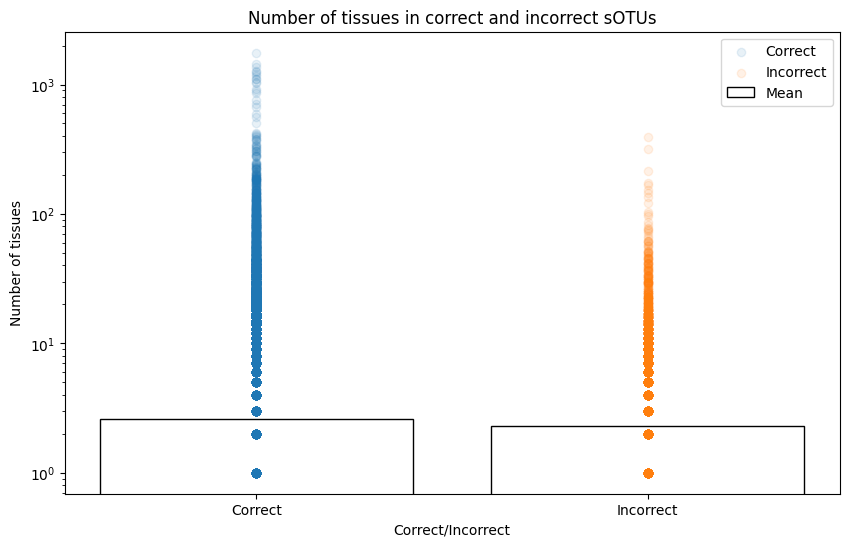

In [ ]:
# compare number of tissues in correct and incorrect sotus
correct_tissues = []
incorrect_tissues = []
for sotu in incorrect_sotus:
    incorrect_tissues.append(len(sotu_to_tissues[sotu]))
for sotu in correct_sotus:
    correct_tissues.append(len(sotu_to_tissues[sotu]))


correct_tissues = pd.Series(correct_tissues)
incorrect_tissues = pd.Series(incorrect_tissues)
plt.figure(figsize=(10, 6))
plt.xlabel('Correct/Incorrect')
plt.ylabel('Number of tissues')
plt.scatter(['Correct'] * correct_tissues.shape[0], correct_tissues, alpha=0.1, label='Correct')
plt.scatter(['Incorrect'] * incorrect_tissues.shape[0], incorrect_tissues, alpha=0.1, label='Incorrect')
plt.bar(['Correct', 'Incorrect'], [correct_tissues.mean(), incorrect_tissues.mean()], label='Mean', edgecolor='black', linewidth=1, facecolor="None")
plt.yscale('log')
plt.title('Number of tissues in correct and incorrect sOTUs')
plt.legend()
plt.show()

In [33]:
# metagenome stats

print(len(incorrect_sotus))
print(len(correct_sotus))
print(len(correct_sotus) / (len(incorrect_sotus) + len(correct_sotus)))
print(incorrect_sotus[:10])

incorrect_metagenome_stats = get_metagenome_stats(incorrect_sotus)
correct_metagenome_stats = get_metagenome_stats(correct_sotus)
display(incorrect_metagenome_stats)
display(correct_metagenome_stats)

correct_metagenome_stats_summary = correct_metagenome_stats.describe()
incorrect_metagenome_stats_summary = incorrect_metagenome_stats.describe()
display(correct_metagenome_stats_summary)
display(incorrect_metagenome_stats_summary)


correct_metagenome_assoc = correct_metagenome_stats['distinctMetagenomeAssoc'].sum()
correct_tax_assoc = correct_metagenome_stats['distinctTaxAssoc'].sum()
incorrect_metagenome_assoc = incorrect_metagenome_stats['distinctMetagenomeAssoc'].sum()
incorrect_tax_assoc = incorrect_metagenome_stats['distinctTaxAssoc'].sum()
num_correct_sotus = len(correct_sotus)
num_incorrect_sotus = len(incorrect_sotus)


data = {
    'Correct': [num_correct_sotus, correct_tax_assoc, correct_metagenome_assoc],
    'Incorrect': [num_incorrect_sotus, incorrect_tax_assoc, incorrect_metagenome_assoc ]
}

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(layout='constrained')
x = np.arange(3)
width = 0.3
multiplier = 0
for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_title('Metagenome and Taxon association for correct and incorrect sOTUs')
ax.set_xticks(x)
ax.set_xticklabels(['Total sOTUs', 'All taxon associations', 'Metagenome associations'])
ax.set_yscale('log')
ax.legend()
plt.show()


# repeat plot, normalize by number of sotus

correct_normalization_const = num_correct_sotus / (num_correct_sotus + num_incorrect_sotus)
incorrect_normalization_const = num_incorrect_sotus / (num_correct_sotus + num_incorrect_sotus)

data = {
    'Correct': [correct_tax_assoc * correct_normalization_const, correct_metagenome_assoc * correct_normalization_const],
    'Incorrect': [incorrect_tax_assoc * incorrect_normalization_const, incorrect_metagenome_assoc * incorrect_normalization_const]
}

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(layout='constrained')
x = np.arange(2)
width = 0.3
multiplier = 0
for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1


ax.set_title('Metagenome and Taxon association for correct and incorrect sOTUs')
ax.set_xticks(x)
ax.set_xticklabels(['All taxon associations', 'Metagenome associations'])
ax.set_yscale('log')
ax.legend()
plt.show()

4189
12498
0.7489662611613831
['u1241', 'u3248', 'u66671', 'u111223', 'u235098', 'u55', 'u410', 'u8694', 'u15348', 'u16225']


,v.sotu,distinctMetagenomeAssoc,distinctTaxAssoc
0,u100196,0,4
1,u100203,3,10
2,u100231,0,5
3,u100263,0,13
4,u100365,1,4
...,...,...,...
4183,u99485,1,3
4184,u9961,2,61
4185,u99639,1,22
4186,u99873,1,12


,v.sotu,distinctMetagenomeAssoc,distinctTaxAssoc
0,u1000126,0,1
1,u1000130,2,4
2,u1000298,3,7
3,u1000424,0,2
4,u1000467,26,327
...,...,...,...
12493,u999597,2,7
12494,u999667,1,1
12495,u999745,1,1
12496,u999760,26,374


## MICE imputation

In [43]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

In [14]:
# want dataset with run, sotu, tissue, organism label, virus family

def get_full_df():
    sql_query = '''
        SELECT *
        FROM (
            SELECT biosample_id, tissue, bto_id
            FROM biosample_tissue
        ) AS t1
        INNER JOIN (
                SELECT bio_sample, sotu, scientific_name, tax_family
                FROM palm_virome
        ) as t2
        ON t1.biosample_id = t2.bio_sample
    '''
    return query_sql(sql_query)

results = get_full_df()


In [17]:
print(len(results))

2176199


In [33]:
full_df = pd.DataFrame(df, columns=['biosample_id', 'tissue', 'bto_id', 'bio_sample', 'sotu', 'scientific_name', 'tax_family'])
full_df = full_df.drop(columns=['biosample_id'])
full_df = full_df.drop_duplicates()
full_df = full_df.dropna()
print(full_df.shape[0])


1333544


In [76]:
# impute_df = sotu_tissues.copy()
impute_df = full_df[['bto_id', 'scientific_name', 'tax_family']]

def label_to_id(df, label):
    # drop na values
    sorted_unique = sorted(df[label].unique())
    label_to_id = {label: i for i, label in enumerate(sorted_unique)}
    df[label] = df[label].map(label_to_id)
    return df

mask_ratio = 0.5
np.random.seed(RANDOM_SEED)
mask = np.random.choice([0, 1], size=impute_df.shape[0], p=[mask_ratio, 1 - mask_ratio])

impute_df = label_to_id(impute_df, 'bto_id')
impute_df = label_to_id(impute_df, 'scientific_name')
impute_df = label_to_id(impute_df, 'tax_family')

# set dtype to dtype="category"
# impute_df['bto_id'] = impute_df['bto_id'].astype('category')
# impute_df['scientific_name'] = impute_df['scientific_name'].astype('category')
# impute_df['tax_family'] = impute_df['tax_family'].astype('category')

impute_df['masked'] = np.where(mask == 0, None, impute_df['bto_id'])
impute_df['test'] = np.where(mask == 0, 1, 0)

imputer = IterativeImputer(max_iter=10, random_state=0, n_nearest_features=5, initial_strategy='most_frequent')
# imputer = SimpleImputer(strategy='most_frequent', missing_values=None)

imputed_values = imputer.fit_transform(impute_df[['masked', 'scientific_name', 'tax_family']])
imputed_values = imputed_values.round(0).astype(int)
impute_df['imputed'] = imputed_values[:, 0]


# evaluate imputation on test set
test_df = impute_df[impute_df['test'] == 1]
correct = test_df[test_df['bto_id'] == test_df['imputed']].shape[0]
total = test_df.shape[0]
accuracy = correct / total

print(accuracy)

/tmp/ipykernel_7195/3507246403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = df[label].map(label_to_id)
/tmp/ipykernel_7195/3507246403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label] = df[label].map(label_to_id)
/tmp/ipykernel_7195/3507246403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

0.00028194868533926826


In [79]:
print(impute_df['imputed'].value_counts())
print(impute_df.head())

1410    232599
1036     84594
806      63947
368      43106
228      37213
         ...  
1172         1
1071         1
1476         1
1518         1
1892         1
Name: imputed, Length: 1817, dtype: int64
   bto_id  scientific_name  tax_family masked  test  imputed
0     244             4044         378   None     1      518
1     244             4044         378    244     0      244
3     244             4044         331    244     0      244
4     244             4044          51    244     0      244
5     244             4044         134   None     1      556


In [73]:
print(test_df['imputed'].value_counts())

1036.140955    82071
1024.655132    33195
1022.051679    23521
1032.600195    13750
1049.770798     9936
               ...  
764.939909         1
784.848668         1
415.739674         1
378.696676         1
414.645392         1
Name: imputed, Length: 39977, dtype: int64


## Graphistry

In [25]:
import graphistry

In [26]:
graphistry.register(api=3, username=os.getenv('GRAPHISTRY_USERNAME'), password=os.getenv('GRAPHISTRY_PASSWORD'))

In [27]:
def get_graphistry_df(sotu_nodes, sotu_edges, communities, correct_sotus, incorrect_sotus):
    nodes = sotu_nodes.copy()
    nodes = nodes.reset_index()
    nodes['displayLabel'] = nodes['sotu']
    # only include nodes in resampled sotus
    nodes = nodes[
        nodes['nodeId'].isin(resampled_sotu_tissues['nodeId'])
    ]
    nodes = nodes.merge(communities, on='nodeId', how='left')
    nodes['communityId'] = nodes['communityId'].fillna(-1)
    nodes['correct'] = np.where(nodes.sotu.isin(correct_sotus), 1, 0)

    # randomly sample 0.5 nodes in each community > 1000
    nodes = nodes.groupby('communityId').apply(lambda x: x.sample(n=10, random_state=RANDOM_SEED, replace=True))
    nodes = nodes.drop_duplicates(subset='nodeId')

    edges = sotu_edges.copy()
    #  remove edges not in resampled nodes
    edges = edges[
        edges['sourceNodeId'].isin(nodes['nodeId']) &
        edges['targetNodeId'].isin(nodes['nodeId'])
    ]

    ## remove edges with nodes in different communities unless percentIdentity >= threshold
    # node_id_to_community = nodes.set_index('nodeId')['communityId'].to_dict()
    # edges['sourceCommunity'] = edges['sourceNodeId'].map(node_id_to_community)
    # edges['targetCommunity'] = edges['targetNodeId'].map(node_id_to_community)
    # edges = edges[
    #     ((edges['sourceCommunity'] == edges['targetCommunity']) & (edges['percentIdentity'] >= 0.7)) 
    #     | (edges['percentIdentity'] >= 0.9)
    # ]

    edges['targetNodeId'] = edges['targetNodeId'].astype(str)
    edges['sourceNodeId'] = edges['sourceNodeId'].astype(str)
    edges['weight'] = edges['percentIdentity'].astype(float)

    edges['weightInt'] = round(edges['weight'] * 100, -1).astype('int32')
    edges = edges[[
        'sourceNodeId', 'targetNodeId', 'relationshipType', 
        'weight', 'weightInt', 
    ]].astype(str)
    edges['weightInt'] = edges['weightInt'].astype('int32')
    
    return nodes, edges

In [28]:
print(most_common_btoId.head())
print(most_common_btoId.shape[0])
print(sotu_tissues['sotu'].nunique())
print(sotu_tissue_rels.head())

          nodeId        btoId scientificName  numRuns
sotu                                                 
u43981   7778443  BTO_0000440          feces     6216
u45804   7782348  BTO_0000440          feces     6053
u38270   7768298  BTO_0000759          liver     5632
u42050   7775988  BTO_0000440          feces     4437
u922455  8643779  BTO_0000713           leaf     4214
257572
257572
   sourceNodeId  targetNodeId    relationshipType  percentIdentity
0       7680426       7750171  SEQUENCE_ALIGNMENT            0.892
1       7680426       7709704  SEQUENCE_ALIGNMENT            0.867
2       7680426       7721464  SEQUENCE_ALIGNMENT            0.865
3       7680426       8083098  SEQUENCE_ALIGNMENT            0.780
4       7683241       8132209  SEQUENCE_ALIGNMENT            0.824


In [29]:
nodes, edges = get_graphistry_df(most_common_btoId, sotu_tissue_rels, communities, correct_sotus, incorrect_sotus)

In [97]:
print(nodes.head())
print(edges.head())

  sourceNodeId targetNodeId    relationshipType              weight  weightInt
0      7680426      7750171  SEQUENCE_ALIGNMENT               0.892         90
1      7680426      7709704  SEQUENCE_ALIGNMENT               0.867         90
2      7680426      7721464  SEQUENCE_ALIGNMENT               0.865         90
3      7680426      8083098  SEQUENCE_ALIGNMENT                0.78         80
4      7683241      8132209  SEQUENCE_ALIGNMENT  0.8240000000000001         80
                      sotu   nodeId        btoId scientificName  numRuns  \
communityId                                                                
1           3771   u446222  8305852  BTO_0000648      intestine       43   
            4826    u12390  7720612  BTO_0000648      intestine       33   
            4852   u864768  8594504  BTO_0003809           soil       33   
            5131   u800071  8538784  BTO_0000440          feces       31   
            12642  u415395  8281911  BTO_0003809           soil       

In [31]:
print(nodes['communityId'].nunique())
print(nodes['communityId'].value_counts().head(10))

10868
490     10
283     10
236     10
662     10
33      10
1054    10
161     10
3891    10
66      10
213      9
Name: communityId, dtype: int64


In [30]:
print(nodes.shape[0])
print(edges.shape[0])

13140
1099


In [32]:
g = graphistry.bind()

g = g.bind(
    source='sourceNodeId',
    destination='targetNodeId',
    edge_weight='weightInt',
).edges(edges)

g = g.bind(
    node='nodeId',
    point_label='displayLabel',
    # point_size=None,
    point_size='numRuns',
).nodes(nodes)

params = {
    'play': 2000,
    'menu': True, 
    'info': True,
    'showArrows': True,
    'pointSize': 2.0, 
    # 'edgeCurvature': 0.5,
    'edgeOpacity': 0.25, 
    'pointOpacity': 1.0,
    # 'lockedX': False, 'lockedY': False, 'lockedR': False,
    'linLog': True, 
    'compactLayout': True,
    'strongGravity': True,
    'dissuadeHubs': False,
    'edgeInfluence': 5,
    # 'precisionVsSpeed': 0, 'gravity': 1.0, 'scalingRatio': 1.0,
    # 'showLabels': True, 'showLabelOnHover': True,
    # 'showPointsOfInterest': True, 'showPointsOfInterestLabel': True, 
    'showLabelPropertiesOnHover': True,
    'pointsOfInterestMax': 10,
}

g = g.settings(url_params=params)

g = g.addStyle(
    bg={
        'color': 'black',
})

# g = g.encode_point_color(
#     'communityColorCodes',
#     categorical_mapping=categorical_colors,
# )


g = g.encode_point_color(
    'correct',
    categorical_mapping={0: 'red', 1: 'green'},
)

g.plot()